# Defactoring ‘Pace of Change’

# Introduction

Code, the symbolic representation of computer instructions that drives software, has always been a part of research methods in literary scholarship. While it is a tired cliché to point to the work of Father Busa and his compatriots at IBM (Jones 2016, Nyhan and Flinn 2016) as foundational work in this respect, it was indeed a very early and important application of computation as a means of analyzing literature. In recent examples we find Broadwell and Tangherlini (2012) who calculated geo-references for a large corpus of folklore stories, and Piper (2015) who sought linguistic identifiers for ‘conversional’ reading (that is, whether texts bear linguistic witness to life altering experiences). When we are lucky we may retrieve the code enabling such feats of computational literary analysis, like the code of Scott Enderle (2016) who crucially contributed to a methodological discussion about perceived “fundamental narrative arcs” from sentiment data in works of fiction or Mike Kestemont et al’s “Lemmatization for variation-rich languages using deep learning” (2017), which improves automatic lemmatization for historical literary texts. Unfortunately, much of the code used in the long history of humanities computing or the recent abundance in digital humanities has not been adequately recognized for its importance in the production of knowledge.

In this article we argue that code cannot be simply regarded as the interim-stage detritus of research; it must be treated as a fundamental part of scholarly output. The increased application of code both as a means to create digital cultural artefacts and as a mechanism for analysis—as demonstrated by the increase of articles such as referenced in the previous paragraph—within the humanities warrants the necessity to elevate code out of the invisible research process and into visible research outputs. The current system of scholarly publishing and communication all but ignores the code of computational work—although it is a lynchpin of the discourse, the code itself is not presented as part of the discourse. We posit that its argumentative role in the evolving epistemology of literary studies (and the humanities in general) warrants a more overt inclusion of code in the scholarly discourse. 

The current systems of scholarly communication are not tailored very well to such inclusion. In the humanities there are no conventions for theorizing, critiquing, interrogating, or peer reviewing code. Nor are there agreed methods on how to read and understand it. Finally, widespread conventions and infrastructure of scholarly publishing do not support the dissemination and preservation of code as part of the scholarly record. But given the increasing role of code and coding in computational and data-intensive humanities research, this absence is increasingly becoming an urgent crisis requiring immediate action.
  
This article is a first step investigating a solution to this problem. We develop one possible method for peer reviewing code. As a result we present *defactoring*, a technique for analyzing and reviewing code used in computational and data-intensive research. In the sections below, we apply this technique to the code underlying a recent publication in the field of literary studies by Ted Underwood and Jordan Sellers titled “How Quickly Do Literary Standards Change?” (2015). This analysis of their work was made possible by the fact that they released preprints and their code on both Zenodo (Underwood 2015) and GitHub (Underwood 2018). Building upon their informally published work, we produced a computational narrative in the form of a Jupyter notebook documenting our experience interrogating and reviewing the code. Following our “close reading” of Underwood and Sellers’s code, we discuss and reflect upon their work and on defactoring as an approach to reviewing scholarly code.

## Code and Peer Review in Literary Scholarship

According to various scholars (e.g. Burgess and Hamming 2011, and Clement 2016) there is a dichotomy between on the one hand a ‘pure’ intellectual realm associated with scholarly writing and academic print publication, and on the other hand the ‘material labour’ associated with the performance of the pure intellectual realm, for example, instrument making or programing. On closer inspection such a dichotomy turns out to be largely artificial. For their argument Burgess, Hamming, and Clement refer to the earlier work of Bruno Latour (1993) who casts the defining characteristic of modernity as a process of ‘purification’ aiming to contrast the human culture of modernity to nature. Burgess and Hamming observe a congruent process in academia: “Within the academy we see these processes of purification and mediation at work, producing and maintaining the distinction between intellectual labor and material labor, both of which are essential to multimedia production” (Burgess and Hamming 2011:¶11). This process serves to distinguish between scholarly and non-scholarly activities: “The distinction between intellectual and material labor is pervasive throughout scholarly criticism and evaluation of media forms. […] In addition, any discussion of scholarly activities in multimedia formats are usually elided in favor of literary texts, which can be safely analyzed using traditional tools of critical analysis” (Burgess and Hamming 2011:¶12). However, as Burgess and Hamming note, this distinction is based upon a technological fallacy already pointed out by Richard Grusin in 1994. Grusin argued that Hypertext has not changed the essential nature of text, as writing has always already been hypertextual through the use of indices, notes, annotations, and intertextual references. To assume that the technology of Hypertext has revolutionarily unveiled or activated the associative nature of text, amounts to the fallacy of ascribing the associative agency of cognition to the technology, which however is of course a ‘mere’ expression of that agency. 

To assume an intellectual dichotomy between scholarly publication resulting from writing versus code resulting from programming, is a similar technological fallacy. To assert that scholarship is somehow bound to print publication exclusively is a akin to ascribing of agency to the technology of written text, because such an understanding of scholarship presupposes that something is scholarship because it is in writing, that writing makes it scholarship. But obviously publication is a function of scholarship and scholarship is not a function of publication, because scholarship does not arise from publication but is ‘merely’ expressed through it.

If scholarship expresses anything through publication it is argument, which is, much more than writing, an essential property of scholarship. Writing is a technology that allows us to express argument. But in essence it does not matter how, or by which form, the argument is made—whether it is made through numbers, pictures, symbols, words, or objects. Those are all technologies that enable us to shape and express an argument. This is not to say that technologies are mere inert and neutral epistemological tools, obviously different technologies shape and affect argument in different ways. Technological choices do matter and different technologies can enrich scholarly argument. Scholarship is thus not bound to the use of text as an epistemological technology, but is essentially found in the shaping of an argument through the use of cognition (obviously) and tools. Producing an argument requires some expressive technology, and the knowledge and ability to wield that technology effectively, which in the case of writing is called ‘literacy’. As Alan Kay (1993) observed, literacy is not just gaining a fluency in technical skills of reading and writing. It also requires a “fluency in higher level ideas and concepts and how these can be combined” (Kay 1993:83). This fluency is both structural and semantic. In the case of writing as technology it is for instance about sentence structure, semantic cohesion between sentences, and about how to express larger ideas by connecting paragraphs and documents. These elements of literacy translate to the realm of coding and computing (Vee 2013) where it is about the syntax of statements and how to express concepts for instance as object classes, methods and functions that call upon other programs and data structures to shape an argument. 
Text and writing may still be the most celebrated semiotic technologies to express an argument, but computer code understood as ‘just another’ literacy (cf. Knuth 1984, Kittler 1993, Vee 2013) means it can thus equally be the medium of scholarly argument. We start from this assertion that coding and code—as the source code of computer programs that is readable to humans and which drives the performative nature of software (Ford 2015, Hiller 2015)—can be inherent parts of scholarship or even code as scholarship by and of itself. That is: we assert that code can be scholarly, that coding can be scholarship, and that there is little difference between the authorship of code or text (Van Zundert 2016). 

There are two compelling reasons why code should be of interest to scholars. Much has been written about the dramatic increase of software, code, and digital objects in society and culture over the last decades often with a lamenting or dystopian view (Morozov 2013, Bostrom 2016). But aside from doomsday prognostications there is ample evidence that society and its artifacts are increasingly also made up of a ‘digital fabric’ (Jones 2014, Berry 2014). This means that the object of study of humanities scholars is also changing—literature, texts, movies, games, music increasingly exist as digital data created through software (and thus code). This different fabric is also branching off cultural objects with different and new properties, for instance in the case of electronic literature (Manovich 2013). It is thus crucial for anybody studying these new forms of humanistic artifacts to have an understanding of how to read code and understand the computational processes it represents. Furthermore, as code and software are increasingly part of the technologies that humanities scholars employ to examine their sources—examples of this abound (e.g. Van Dalen & Van Zundert 2007; Tangherlini 2012; Piper 2015; Kestemont, Moens, and Deploige 2015; etc.) understanding the workings of code is therefore becoming a prerequisite for a solid methodological footing in the humanities. 
Over the last decade code and its creation have become substantial parts of the objects and methods of study within the humanities (cf. for instance Underwood and Sellers 2015; Ramsay 2011). Coding and code now represent the material labour and output of scholarly effort and analysis, and as such they constitute important parts of scholarly epistemology. Conventional epistemological instruments—such as historiography, close reading, deconstruction and hermeneutics—that constitute large or important parts of analysis are conscientiously accounted for in scholarly publications. In effect most scholarly articles are de facto inscriptions of such epistemological tools: they inscribe the argument a humanist shaped using this particular abductive style of reasoning, which is quite indigenous to the humanities. Afterwards these inscriptions are offered to others scholars for scrutiny and evaluation, making the research accountable through peer review. Confusingly, in the humanities analysis and inscription are often one and the same: the argument is shaped by creating text, and the reporting is a polished version of the argument inscribed as text. A publication thus is a report that accounts for argument and research, and all that pertains to is: topic, method, data, analysis, findings. If code and coding are substantial constituting parts of the argument, then it would be quite extraordinary to not subject these to the same forms of scrutiny and accountability. Yet code hardly ever is regarded as scholarly output, and if it is published at all it is seldom or never evaluated (cf. Schreibman, Mandell, and Olsen 2011).

The current system of scholarly publishing and communication all but ignores the material labor and inscriptions of code in computational research. Although code underpins important parts of the discourse, they are themselves not presented as elements in the discourse. Their status is akin to how data and facts are colloquially perceived, as givens, objective and neutral pieces of information or observable objects. But like data (Gitelman 2013) and facts (Betti 2015), code is unlikely to be ever ‘clean’, ‘unbiased’, or ‘neutral’ (cf. also Berry 2014). Code is the result of a particular literacy (cf. for instance Knuth 1984, Kittler 1993, Vee 2013) that encompasses the skills to read and write code, create and relate larger code constructs and code objects and to express concepts, ideas, and argument. And like text code can be wielded to gain a certain intended effect, or have unintended side effects (cf. e.g. McPherson 2012). In other words: code has rhetorics. Therefore, what Joanna Drucker (2011) holds about data—that rather than ‘given’ data should be called ‘capta’, i.e. ‘that which was taken’—is the more true for code: it is a symbolic system with its own rhetoric and cultural embeddedness (Marino 2006) and latent agency (Van Zundert 2016). Thus, rather than accepting code and its workings as some mathematically neutral mechanism, it should be regarded as part of a discourse that should be under peer scrutiny as a whole.
However, the acceptance of code as another form of scholarly argument presents problems to the current scholarly process of evaluation because of a lack of well developed methods for reviewing and critiquing scholarly code. Digital humanities as a site of production of non-conventional research outputs—digital editions, web based publications, new analytical methods, and computational tools for instance—has spurred the debate on evaluative practices in the humanities, exactly because practitioners of digital scholarship acknowledge that much of the relevant scholarship is not expressed in the form of traditional scholarly output. Yet the focus of review generally remains on “the fiction of ‘final outputs’ in digital scholarship” (Nowviskie 2011), on old form peer review (Antonijevic 2016), and on approximating equivalencies of digital content and traditional print publication (Presner 2012). Discussions around the evaluation of digital scholarship have thus “tended to focus primarily on establishing digital work as equivalent to print publications to make it count instead of considering how digital scholarship might transform knowledge practices” (Purdy and Walker 2010:178; Anderson and McPherson, 2011). As a reaction digital scholars have stressed how peer review of digital scholarship should foremost consider how digital scholarship is different from conventional scholarship. They argue that review should be focussed on the process of developing, building, and knowledge creation (Nowviskie 2011), on the contrast and overlap between the representationality of conventional scholarship and the strong performative aspects of digital scholarship (Burgess and Hamming 2011), and on the specific medium of digital scholarship (Rockwell 2011).

But the debate on peer review in digital scholarship has been geared much to high level evaluation, concentrating for instance on the issue how digital scholarship could be reviewed in the context of promotion and tenure track evaluations. Very little has been proposed as to concrete techniques and methods for the practical peer review of program code.^[The situation is different in the sciences, where more concrete experiments with code review are found. For instance the Josurnal of Open Source Software (http://joss.theoj.org/about) is attempting to alleviate these challenges by creating a platform for the submission, review, and validation of scientific code and software.] Existing guidance pertains to digital objects such as digital editions (Sahle and Vogler 2014) or to code as cultural artefact (Marino 2006), but no substantial work has been put forward on how to peer review *scholarly* code. We are left with the rather general statement that “traditional humanities standards need to be part of the mix, [but] the domain is too different for them to be applied without considerable adaptation” (Smithies 2012), and the often echoed contention that digital artefacts should be evaluated–*in silico*–as they are and not as to how they manifest in conventional publications. The latter argument probably most succinctly put by Geoffrey Rockwell (2011): “While such narratives are useful to evaluators […] they should never be a substitute for review of the work in the form it was produced in.”

Yet, the problem is growing more urgent, as the ‘Syuzhet case’ in particular pointed out. Joanna Swafford detected an odd behavior in the Syuzhet software for sentiment mining. Applying an “overly simplified” model for sentiment analysis and a “poorly chosen” signal processing filter the software behaved erroneously and could even to inverted results, reporting emotional ‘highs’ where novels would actually exhibit an emotional ‘low’. at the novel’s emotional lows (Swafford 2016). Scott Enderle (2015) questioned on an even more fundamental level if a Fourier transform of word frequency histograms (i.e. a reductionist smoothing or simplification of a more granular data chart) actually meant anything at all. Having a sound peer review system for code would have caught these defects at an early stage, but failing such a system Swafford contends: “unless we focus more on creating quality-control systems for our work, we run the risk of drawing erroneous conclusions based on messy data and faulty tools.” 

Beyond the theoretical and methodological challenges, reviewing code introduces practical challenges as well. Foremost is the problem of determining what code is in scope for review. The rabbit hole runs deep as research code is built on top of standard libraries, which are built on top of programming languages, which are build on top of operating systems, and on and on. Methodologically, a boundary must be drawn between the epistemologically salient code and the foundational context within which it executes. Hinsen (2017) makes a useful distinction that divides scientific software into four layers. First, there is a layer of *general software*. Generalized computational infrastructure like operating systems, compilers, and user interfaces fall into this category. Generic tools like Microsoft Word or Apache OpenOffice or general purpose programming language like Python or C, while heavily used in scientific domains, also have a rich life outside of science (and academia more broadly). The second layer comprises *scientific software*. Applications, libraries, or software packages that are not as general purpose as layer one, rather they are designed for use in scientific or academic activities. For example, Stata or SPSS for statistical analysis, Open-MPI for parallel computing in high performance computing applications, or Globus as a general tool for managing data transfers, AntConc for text corpus analytics, Classical Text Editor to create edition of ancient texts, or Zotero for bibliographic data management. A third layer comprises *disciplinary software*, of which the Syuzhet R package for literary analysis is an excellent example. The design of Syuzhet means it can be used in a variety of analyses, not just the analysis performed by Jockers (2014, 2015). Lastly, there is a fourth layer of *bespoke software*. This layer comprises project specific code developed in pursuit of the very specific set of tasks associated with a particular analysis. This is the plumbing connecting other layers together to accomplish a desired outcome. Unlike the previous layers, this code is not meant to be generalized or reused in other contexts. 

As argued above: increasingly project specific, *bespoke code* is created and used in textual scholarship and literary studies (cf. for instance Enderle 2016; Jockers 2013; Piper 2015; Rybicki, Hoover, and Kestemont 2014; and Underwood 2014). The algorithms, code, and software underpinning the analyses in these examples are not completely standardized ‘off the shelf’ software projects or tools. These code bases are not a software package such as AntConc that can be viewed as a generic distributable tool. Instead these codebases are (in Hinsen’s model) the fourth layer of bespoke code: they are one-off highly specific and complex analytical engines, tailored to solving one highly specific research question based on one specific set of data. Reuse, scalability, and ease-of-use are—justifiably (Baldrigde 2015)—not specific aims of these code objects. This is code meant only to run once.

Because of their specificity and their pivotal analytic function we must regard bespoke code as an inherent part of the particular scholarly argument to which they contribute. And as such they require and deserve specific and rigorous review, like any argument in humanities research. How such peer review should be conducted is, however, an unexplored frontier. We introduce *defactoring* as a method for peer reviewing and critically analyzing the bespoke code of computational research. 

## Defactoring

We introduce an experimental technique called *defactoring* to address the challenges of critically examining and  peer reviewing code. We expand on ideas of Braithwaite (2013) who considered defactoring as the process of de-modularizing software to reduce its flexibility in the interest of improving design choices. This is counter intuitive to software engineering where best practices prefer increased generalization, flexibility, and modularization. Refactoring and software engineering best practices emphasize writing code that can be managed according to the organizational labor practices of software production and object oriented design, breaking blocks of code into independent units that can be written and re-used by teams of developers. While these best practices make sense for code intended for the first three layers of software the fourth layer, bespoke code, could have a different style with less emphasis on abstraction and modularity because such code becomes harder to read as a narrative. 

Here we are interested in elucidating what a process of defactoring code looks like for the purposes of reviewing code, which implies reading code. In our expanded notion of the concept, defactoring can be understood as a close reading of source code–and if necessary a reorganization of that code–to create a narrative around the function of the code. This technique serves multiple purposes: critically engaging the workings and meanings of code; peer reviewing code; understanding the epistemological and methodological implications of the inscribed computational process; and a mechanism for disseminating and teaching computational methods. We use defactoring to produce what might prospectively be called the first critical edition of source code in the digital humanities by unpacking Ted Underwood and Jordan Sellers’s code from their article “How Quickly Do Literary Standards Change?” (Underwood and Sellers 2015).^[Interestingly, the article and the accompanying code by Underwood and Sellers have been subject to scrutiny before. The publication and code served as a use case for a workflow modeling approach aimed at replication studies (Senseney 2016). We are not primarily interested in replication per se, but the example serves to show how valuable the publication of open source/open access code and data are for replication and peer review.]

The codebase that Underwood and Sellers produced and that underpins their argument in “How Quickly to Literary Standards Change” is a typical example of multi layered code. The code written by Underwood and Sellers is bespoke code, or fourth layer code in Hinsen’s model of scientific software layers. When dealing with a scholarly publication such as “How Quickly Do Literary Standards Change?”, the focus of peer review should be on layer four, the bespoke code.^[This may seem to contradict the fact that an urgent problem was pointed out with the Syhuzet package which is supposed to be layer 3 software. This however supports our argument as the Syhuzet package should have undergone peer review of a form as we argue and present here when it was still layer four code in its experimental stages. The fact that a defect in the software was confirmed is exactly due to the lack of such peer review as we propose.] The code from the lower layers, while extremely important, should be reviewed in separate processes. As Hinsen points out, layer four software is the least likely to be shared or preserved because it is bespoke code intended only for a specific use case, this means it most likely has not been seen by anyone except the original authors. Lower layer software, such as scikit-learn, has been used, abused, reviewed, and debugged by countless people. There is much less urgency therefore to focus the kind of intense critical attention that comes with peer review on this software because it already has undergone so much scrutiny.

There is no established definition of 'defactoring' or its practice. Defactoring provides a method and conceptual framework for close reading the code in data intensive and computational digital humanities research for the purposes of deep understanding. How this process of understanding is performed is not prescribed and could take many forms. One potential approach would be to simply run the code as-is in a similar workflow but perhaps with different data, however this would not generate much insights as the code would be treated as a black box. Another approach might be reverse engineering, which would try to approximate the code’s function by comparing inputs and outputs (Seaver 2014). For closed source code, this might be the only option. Writing automated tests that gauge the different responses to input might yet be another approach (Berry 2014). Here however we are interested in a deep and intimate understanding of code (cf. Frabetti 2012) to understand how it is adding or changing methodology and how it could be critiqued.

Defactoring is a process or possible a tool for ‘opening the black box’ of computational and data intensive scholarship. While it shares some similarity to the process of refactoring–in that we are "restructuring existing computing code without changing its external behavior"–refactoring restructures code into separate functions or modules to make it more reusable and recombinable. Defactoring does just the opposite. We have taken code that was broken up over several functions and files and combined it into a single, linear narrative. This process invokes a deconstructive analytic in which we have internally examined and reconfigured the code that Underwood and Sellers published, but externally there is no change to the behavior or outputs–just like refactoring. 
Our development of defactoring as a method of code analysis is deeply imbricated with a technical platform (just as all computational research is as well). But rather than pushing the code into a distant repository separate from the prosaic narrative, we compose a computational narrative (Perez and Granger 2015)—echoing Knuth’s literate programming (1984)—whereby Underwood and Sellers’s data and code are bundled with our expository descriptions and critical annotations. This method is intimately intertwined with the Jupyter Notebook platform which allows for the composition of scholarly and scientific inscriptions that are simultaneously human and machine readable. The particular affordances of the Notebook allow us to weave code, data, and prose together into a single narrative that is simultaneously readable and executable. Given our goals to develop a method for critically engaging computational scholarship, it is imperative we foreground Underwood and Sellers's code and the Jupyter Notebooks enables us to do so.


## Pace of Change

The code we defactor is that which underlies an article that Underwood and Sellers published in Modern Language Quarterly (2016): The *Longue Durée* of Literary Prestige. This article was the culmination of prior work in data preparation (Underwood and Sellers, 2014), coding (Underwood and Sellers 2015a ad 2018) and preparatory analysis (Underwood and Sellers, 2015). The main thrust of the MLQ article seems to be one of method: "Scholars more commonly study reception by contrasting positive and negative reviews. That approach makes sense if you’re interested in gradations of approval between well-known writers, but it leaves out many works that were rarely reviewed at all in selective venues. We believe that this blind spot matters: literary historians cannot understand the boundary of literary distinction if they look only at works on one side of the boundary" (Underwood and Sellers 2016:324). To substantiate their claim Underwood and Sellers begin their "inquiry with the hypothesis that a widely discussed “great divide” between elite literary culture and the rest of the literary field started to open in the late nineteenth century". To this end they compare volumes of poetry that were reviewed in elite journals in the period 1820-1917 with randomly sampled volumes of poetry from the HathiTrust Digital Library from the same period. They filtered out volumes from the HathiTrust resource that were written by authors that were also present in the reviewed set, effectively ending up with non-reviewed volumes. In all they compare 360 volumes of ‘elite’ poetry and 360 non-reviewed volumes. For each volume the relative frequencies of the 3200 most common words are tallied and they apply linear regression to these frequency histograms. This linear regression model enables them finally to predict whether a sample that was not part of the regression data would have been reviewed or not. The accuracy of their predictions turn out to be between 77.5 and 79.2 percent. This by itself demonstrates that there is some relationship between some poetry's vocabulary and that poetry being reviewed. But more importantly, what they can glean from their results is that the traditional idea that literary fashions are pretty stable over some decades and are then revolutionized towards a new fashion deserves revisiting: the big 19th century divide turns out not to be a revolutionary change but a stable and slowly progressing trend since at least since 1840. Underwood and Sellers conclude: none of our "models can explain reception perfectly, because reception is shaped by all kinds of social factors, and accidents, that are not legible in the text. But a significant chunk of poetic reception can be explained by the text itself (the text supports predictions that are right almost 80 percent of the time), and that aspect of poetic reception remained mostly stable across a century". Sudden changes also do not emerge if they try to predict other social categories like genre or authorial gender. They finally conclude that the question why the general slow trend they see exists is too big to answer from these experiments alone, because of the many social factors that are involved.

Underwood and Sellers purposely divided their code into logical and meaningful parts, modules, and functions stitched together into a data processing and analysis script. We found to better understand the code as readers (vs. authors) and to narrate its execution it was necessary to restructure, defactor, the code into what is usually understood as a poor software engineering practice, namely making a  single long, strongly integrated, procedural process. This makes the code a linear narrative, which is easier for humans to read while the computer is for the most part indifferent. There is a tension between these two mutually exclusive representations of narratives with code divided and branched, emerging from the process of development by software engineers, and with prose as a linear narrative intended for a human reader. What we observed is that the processes of deconstructing literature and code are not symmetrical but mirrored. Where deconstructing literature usually involves breaking a text apart into its various components, meanings, and contexts, deconstructing software by defactoring means integrating the code’s disparate parts into a single, linear computational narrative. “Good code,” in other words, is already deconstructed (or 'refactored') into modules and composable parts. For all practical purposes we effectively are turning “well engineered” code into sub-optimal code full of 'hacks' and terrible 'code smells' by de-modularizing it. However, we argue, this “bad” code is easier to read and critique while still functioning as its authors intended.

Defactoring injects the logical sections of the code, parts that execute steps in the workflow, with our own narrative reporting on our understanding of the code and its functioning at that moment of the execution. The Jupyter Notebook platform makes this kind of incremental exploration of the code possible and allows us to present a fully functioning and executable version of Underwood and Sellers’s code that we have annotated. Reading (and executing along the way) this notebook therefore gives the reader a close resembling of the experience of how we as deconstructionists 'closely read' the code.^[To support ourselves in the reading process we found it useful to keep track of the 'state' of the code as it was executing. We implemented this by listing all the 'active' variables and their values at each step of the process. The explanation of each step is therefore also amended with a listing of these variables.]

## Defactoring in Practice

At a practical level, we have copied code code from Underwood and Sellers Pace of Change git repository and restructured their code into a Jupyter Notebook. Transforming Underwood and Seller’s code from a set of Python scripts into the notebook involved a series of transformations to their code. The provenance of this effort has been preserved because we did all of our work in the fork of their version repository, visible via the git history command.

Underwood and Sellers’s wrote their code to make it easy to replicate their results by running a single command. One of our first tasks was to trace their code following the path of execution from the initial command to the output data files. By reading the code that spanned multiple python script, we could obtain a rough idea of how Underwood and Sellers’s analysis of poetry volumes was performed in practice. The first step of reading their code involved translating their python scripts into a Jupyter Notebook.Plain text files leave much to be desired with trying to critically interrogate code, the Jupyter Notebook format and platform enables a much richer reading experience. Translating Underwood and Sellers’s scripts involved copying snippets of code from multiple Python (.py) files into a single executable notebook. For code that was not already authored in a notebook, this requires significant effort curating and restructuring the code to fit the linear structure of the notebook while preserving the functionality of Underwood and Sellers’s scripts. 

Not all of the code in the git repository was copied into the notebook for three main reasons. First, not all of the code included in the files was actually needed to replicate the analysis. The repository includes additional code, one could call it “cruft”, from Underwood and Seller’s exploratory analysis or earlier iterations of the analytical process. For example, the file SonicScrewdiver.py is never called upon although, based upon the name, we might hypothesize it is an important catch-all module for a variety of different functions. Other sections of the code are commented out and thus never executed (such as binormal_select discussed below). As part of the defactoring process, we opted to not include unused functions or code blocks. Another reason that the code of Sellers and Underwood was not copied verbatim is because we do not represent all possible executions paths of the code. Code usually includes conditional statements that control the flow of execution creating different branches of code that execute. Each condition causes a different block of code to be executed, possibly also in a different order. Even relatively simple code can result in a combinatory explosion of different execution paths. It is infeasible to critically examine each of these executions paths individually. At the beginning of Pace of Change, for instance, there are six options for slicing the data in the module called “replicate.py”, which is the entry-point for re-running the analysis, each tied to a different set of execution paths. In this notebook we follow the default option, “full”, which models the entire dataset. The third reason we did not include some code was because of the use of external libraries. While most of the scripts are bespoke code for working with unique data, some sections of the code, like the logistic regression, are part of a third-party library, scikit-learn, that for a multitude of reasons (including practicality) we decided to “step over” and not defactor. When trying to follow the path of execution for any program one needs to recognize it is “turtles all the way down.” To make our task possible, we have to make a decision about how far down the path of execution we would perform our analysis. Following also Hinsen (2017. cf. the section ‘Background’), we drew a hard boundary at code that was not written by Underwood and Sellers themselves, thus code beyond the so-called layer four code in Hinsen’s model. Analysis of subsequent third-party libraries, and standard python libraries such as scikit-learn should be left to other processes of peer review.

Underwood and Seller’s code is stored within four Python files, `replicate.py`, `parallel_crossvalidate.py`, `metafilter.py`, and `modelingprocess.py`. Through the process of defactoring we have copied some, but not all, code from the Python text files to a Jupyter Notebook. This process has transformed the structure and flow of the code, but not the functionality. Like *refactoring*, the inputs and outputs and overall functionality remain the same, but our process has restructured the code to be much more readable as a narrative with our own expository text intermixed with executable blocks of code.

![Defactoring code from python files to the notebook](notebook_resources/defactoring.png)

In order for the code to execute seamlessly within the notebook, we had to make minor changes and tweaks to the code. These changes fall into 4 categories:

* *defactoring functions* - This is the most significant of the changes. When we defactor a function we take the function's code and move it to the global namespace. This has the effect of elimiating the function and just making it part of the main execution path. 
* *defactoring definitions* - Not all functions can be fully defactored. Functions that are called more than once or those that are short have been kept as re-usable functions. Defactoring Definition cells define the functions above the code cells that use them (preventing errors).
* *defactoring namespace* - Because we have defactored some of the functions and their function calls some of the variables in the namespace need to be mapped to each other. This happens, for instance, we the return value of a defactored function needs to be stored in a differently named variable so the rest of the code can access it (resolving the fact we have moved a function's internal variables into a global namespace).
* *defactoring inspections* - When we want to inspect the state of the process, we insert an inspection cell that prints the values of the variables of interest. These allow us the ability to inspect the state of the process as it is running; essentially debugging intermediate states.
* *defactoring import* - Because the code is reliant upon external and third party functions, we need to import that code into the global namespace. This cell contains all of those imports.

### How to Read this Notebook

One of the advantages to defactoring a function is that it affords us the ability to insert critical commentary into the code constituting the function itself. An unfortunate side-effect is that this makes keeping track of one’s place in the code a little more difficult.

The notebook is divided into a series of cells, *code cells* and *text cells*. Code cells contain python code mostly written by Underwood and Selles, but with a few modifications by us. Code cells can be executed by clicking on the run button in the toolbar above this notebook. Care should be taken that all cells are executed in the order that they appear. This is easiest achieved by using the run button to step through all cells (as it will also step over text cells) consecutively. We have broken up the code of Underwood and Sellers and inserted text cells, written by us, which discuss and explain what is happening in the code cells. In most cases the expository text is below the code cell. In the critical examination of the code we will be using a fair bit of coding language jargon. Although a very deep grasp of these coding concepts will not be needed, a certain level of code concepts literacy (Vee 2013) will facilitate a speedier comprehension of our narrative.


## Defactoring Pace of Change


The code expressed below has nine steps:
* [Importing Libraries](#Importing-Libraries) - Loads the necessary Python libraries needed for the analysis.
* [Setting Parameters](#Setting-Parameters) - Specifies parameters for the loading, cleaning, and labeling of data as well as sets conditions for the logistic regression.
* [Preparing Metadata](#Preparing-MetaData) - Generates a list of *.tsv files from the `poems/` directory. 
    * [Cleaning Metadata](#Cleaning-Metadata) - Loads the metadata file, `poemetadata.csv` and performs some cleaning of the metadata to make labeling easier.
    * [Sorting Training Data](#Sorting-Data) - Sort the volumes into two bins, reviewed and not reviewed using the cleaned metadata.
* [Transforming Words into Features](#Transforming-Words-into-Features) - Identifies the 3,200 most common words in the corpus. Those most common words will be the features for the regression.
    * [Filtering Authors](#Filtering-Authors) - Removes poems by authors who have been reviewed.
    * [Filtering Words](#Filtering-Words) - Remove any words from the poem data that are not in the most-common feature list.
* [Training Predictive Models](#Training-Predictive-Models) - Run a separate logistic regression for each volume, using a single volume as held-out data and measure each model's predictive power.
* [Modeling Coefficients](#Modeling-Coefficients) - Run a single logistic regression over all the data to inspect the salient coefficients.
* [Plotting Results](#Plotting-Results) - Generate a plot showing the accuracy of the predictive models.



### Importing Libraries

This section loads a series of libraries used in the pace of change analysis.

In [1]:
### DEFACTORING IMPORT
import os
import csv 
import random 
from collections import Counter 

import numpy as np 
import pandas as pd 

from multiprocessing import Pool 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.linear_model import LogisticRegression

We begin examination of the code by importing a series of Python libraries into working memory. This is the boundary between the layers of bespoke code and existing general purpose (os, csv, random) and scientific computing libraries (numpy, pandas, sklearn). Following from Hinsen’s model of layers of scientific software, what is missing is the inclusion of libraries from the *disciplinary* layer. The most specific library in terms of use in the Hinsen model is the LogisticRegression model from Scikit-Learn, but we’d argue this lives in layer two, scientific software, because it  is broadly applicable across a variety of disciplines. This begs the question, what or where are the disciplinary Python libraries for literary history or digital humanities? What functions would the perform? What domain specific tasks or methods need to encoded into a disciplinary library? Perhaps it is too early to for such libraries to exist as the practices of computational and data intensive research are still new (in literary history).

### Setting Parameters

The first section of the code sets a series of parameters specifying what data to process, where data are located, and parameters for the logistic regression. While there is no complex logic or work being done in this section, many assumptions and important distinctions that shape the execution of subsequent code are defined here.

In [2]:
## PATHS.

sourcefolder = 'poems/'
extension = '.poe.tsv'
classpath = 'poemeta.csv'
outputpath = 'mainmodelpredictions.csv'

## EXCLUSIONS.

excludeif = dict()
excludeif['pubname'] = 'TEM'
# We're not using reviews from Tait's.

excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.

excludeifnot = dict()
excludeabove = dict()
excludebelow = dict()

excludebelow['firstpub'] = 1700
excludeabove['firstpub'] = 1950
sizecap = 360

# For more historically-interesting kinds of questions, we can limit the part
# of the dataset that gets TRAINED on, while permitting the whole dataset to
# be PREDICTED. (Note that we always exclude authors from their own training
# set; this is in addition to that.) The variables futurethreshold and
# pastthreshold set the chronological limits of the training set, inclusive
# of the threshold itself.

## THRESHOLDS

futurethreshold = 1925
pastthreshold = 1800

# CLASSIFY CONDITIONS

positive_class = 'rev'
category2sorton = 'reviewed'
datetype = 'firstpub'
numfeatures = 3200
regularization = .00007


paths = (sourcefolder, extension, classpath, outputpath)
exclusions = (excludeif, 
              excludeifnot, 
              excludebelow, 
              excludeabove, 
              sizecap)
thresholds = (pastthreshold, 
              futurethreshold)
classifyconditions = (category2sorton, 
                      positive_class, 
                      datetype, 
                      numfeatures, 
                      regularization)

The parameters defined in the code cell above are a set of knobs and switches used to tweak the performance and execution of the computational modeling process. Underwood and Sellers have collected the parameters into four categories: *paths*, *exclusions*, *thresholds*, and *classifyconditions*. These categories are simultaneously distinguished discursively through the code comments (the lines beginning with a #) and technologically through four variable assignments, `exclusions`, `thresholds`, and `classifyconditions`. Because technically speaking the grouping of parameters is not strictly necessary, each of these four variables embody stylistic choices of the authors as a means of organizing and structuring the information they are encoding in Python.    

The variables in `paths` specify the location of the data and metadata files as well as where to write the output files at the completetion of the analysis. The variables in `exclusions` specify data and types of data to be excluded from the analysis, such as reviews from *Tait's Endinburgh Magazine* (https://en.wikipedia.org/wiki/Tait%27s_Edinburgh_Magazine), which we infer from the author's comments. Additional exclusions specify temporal boundaries from 1700 to 1950. An further set of two variables in `thresholds` also articulates a temporal boundary from 1800 to 1925. The comments indicate this distinguishes the temporal window for datasets using in *training* versus those used during *prediction.* The variables in `classifyconditions` are important parameters for the logistic regression, specifying the number of variables to train the model upon as well as setting the regularization parameter (`regularization`) for the logistic regression. What is not well documented here, is why the value .00007 was chosen over other values.


### Preparing Metadata

With the preparation of metadata we begin to see some logical work of Pace of Change being conducted. The code in this section has two subsections, one to clean the metadata and another to sort the training data. All of the work in this section focuses on preparing the metadata, identified in the `classpath` variable and the filenames of the individual data files in the `sourcefolder`. The main task of this section is to organize the metadata of the volumes and their associated labels (positive or negative) for training the logistic regression. All of the code in this section attends to the cleanliness of the metadata; we will not start digging into the data itself until the next section.

In [3]:
### DEFACTORING FUNCTION
### def create_model(paths, exclusions, thresholds, classifyconditions):
''' This is the main function in the module.
It can be called externally; it's also called
if the module is run directly.
'''
verbose = False

if not sourcefolder.endswith('/'):
    sourcefolder = sourcefolder + '/'

# This just makes things easier.

# Get a list of files.
allthefiles = os.listdir(sourcefolder)
# random.shuffle(allthefiles)

volumeIDs = list()
volumepaths = list()

for filename in allthefiles:

    if filename.endswith(extension):
        volID = filename.replace(extension, "")
        # The volume ID is basically the filename minus its extension.
        # Extensions are likely to be long enough that there is little
        # danger of accidental occurrence inside a filename. E.g.
        # '.fic.tsv'
        path = sourcefolder + filename
        volumeIDs.append(volID)
        volumepaths.append(path)

This code assembles a list of volume identifiers (`volumeIDs`) and file paths (`volumepaths`) by readings the directory listing of files in the `poems/` directory (`sourcefolder`). The filenames are in and of themselves a source of metadata, but as we will see in the code below, they need to be reconciled with the metadata stored separately from the data files. 

We are curious about the contents of the `volumeIDs` and `volumepaths` variables. 

In [4]:
### DEFACTORING INSPECTION
### Inspect the two variables defined in the codecell above.
### We know they are lists so lets just look at the first item.
print("The first item in volumeIDs is: ", volumeIDs[0])
print("The first item in volumepaths is: ",volumepaths[0])

The first item in volumeIDs is:  loc.ark+=13960=t5n881k59
The first item in volumepaths is:  poems/loc.ark+=13960=t5n881k59.poe.tsv


The code has created an alighment between identifiers in the metadata records and the filename idententifiers of the TSV data files timeselves (located in the `poems/` folder). These identifiers, `dul1.ark+=13960=t5fb5xg2z`, are the threads that stitch together the various representations of the (meta)data.

#### Cleaning Metadata

In [5]:
### DEFACTORING FUNCTION DEFINITION
### we need these helper functions for execute the next code cell

def dirty_pairtree(htid):
    period = htid.find('.')
    prefix = htid[0:period]
    postfix = htid[(period+1): ]
    if '=' in postfix:
        postfix = postfix.replace('+',':')
        postfix = postfix.replace('=','/')
    dirtyname = prefix + "." + postfix
    return dirtyname

def forceint(astring):
    try:
        intval = int(astring)
    except:
        intval = 0

    return intval

This code cell defines two functions used in the code below. The first is `dirty_pairtree()`, which cleans up the identifiers in the data. The issue stems from the fact that the HathiTrust (where Underwood and Sellers got their data from) uses IDs that cannot be expressed on the filesystem and Underwood and Sellers encoded ID metadata in filenames. The “/” and “:” characters in the IDs cannot be part of a file name. So, because the volumes are stored as individual files they have a “+” and an “=” instead. However, the IDs are stored in the original format in the metadata file so the IDS have to be transformed back into the original HathiTrust format.  The second function is called `forceint()` and transforms numbers expressed as Python strings into the python integer data type with a it of error handling in the case values that throw and error when being cast as an integer.

What does the the metadata look like? We can inspect the beginning of file to get a sense of the material conditions of the metadata.

In [6]:
### DEFACTORING INSPECTION
metadata_file = pd.read_csv(classpath)
#print(metadata_file.shape)
print("The metadata files has {} rows and {} columns.".format(
    *metadata_file.shape))
metadata_file.head()

The metadata files has 728 rows and 22 columns.


,docid,actualdate,inferreddate,firstpub,recept,recordid,OCLC,author,imprint,enumcron,...,judge,impaud,yrrev,pubname,birth,gender,nationality,othername,notes,canon
0,loc.ark+=13960=t8sb4zz1q,1921,1921,1921,addcanon,537314.0,NaN,"Lawrence, D. H.",New York;T. Seltzer;1921.,NaN,...,NaN,NaN,NaN,NaN,1885,m,uk,NaN,NaN,y
1,uc1.b3342759,1919,1919,1919,random,7930862.0,NaN,"Wigren, Bessie C.",Boston;The Poet Lore Company;c1919,NaN,...,NaN,NaN,NaN,NaN,1874,f,us,NaN,NaN,NaN
2,uc1.b4100590,1918,1918,1918,reviewed,6154122.0,2143179.0,"Waugh, Alec,",London;G. Richards;1918.,NaN,...,NaN,NaN,1918.0,EGO,1898,m,uk,NaN,NaN,NaN
3,uc1.b3340220,1918,1918,1918,reviewed,7917249.0,12688503.0,"Nightingale, M.",Oxford [Oxfordshire;B.H. Blackwell;1918.,NaN,...,neg,NaN,1919.0,EGO,1879,f,uk,NaN,NaN,NaN
4,uc2.ark+=13960=t0ft8gj1k,1918,1918,1918,reviewed,7657411.0,2518108.0,"Faber, Geoffrey,","Oxford;B. H. Blackwell;New York;Longmans, Gree...",NaN,...,NaN,NaN,1918.0,EGO,1889,m,uk,NaN,NaN,NaN


Using *defactoring inspection* we can actually look at the metadata file and inspect the first five rows of metadata. By blending the original code with our inspection code and narrative the metadata becomes less of a conceptual abstraction and more of a tangible, material object that we can interrogate. Here we can see the file as 728 rows and 22 columns as well as the contents of the first five rows.

In [7]:
### DEFACTORING FUNCTION 
### def get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove):
'''
As the name would imply, this gets metadata matching a given set of volume
IDs. It returns a dictionary containing only those volumes that were present
both in metadata and in the data folder.

It also accepts four dictionaries containing criteria that will exclude volumes
from the modeling process.
'''
print(classpath)
metadict = dict()

with open(classpath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)

    anonctr = 0

    for row in reader:
        volid = dirty_pairtree(row['docid'])
        theclass = row['recept'].strip()

        # I've put 'remove' in the reception column for certain
        # things that are anomalous.
        if theclass == 'remove':
            continue

        bail = False
        for key, value in excludeif.items():
            if row[key] == value:
                bail = True
        for key, value in excludeifnot.items():
            if row[key] != value:
                bail = True
        for key, value in excludebelow.items():
            if forceint(row[key]) < value:
                bail = True
        for key, value in excludeabove.items():
            if forceint(row[key]) > value:
                bail = True

        if bail:
            print("DEFACTORING: Excluding volume with id "+volid) ### DEFACTORING CODE
            continue

        birthdate = forceint(row['birth'])

        pubdate = forceint(row['inferreddate'])

        gender = row['gender'].rstrip()
        nation = row['nationality'].rstrip()

        #if pubdate >= 1880:
            #continue

        if nation == 'ca':
            nation = 'us'
        elif nation == 'ir':
            nation = 'uk'
        # I hope none of my Canadian or Irish friends notice this.

        notes = row['notes'].lower()
        author = row['author']
        if len(author) < 1 or author == '<blank>':
            author = "anonymous" + str(anonctr)
            anonctr += 1

        title = row['title']
        canon = row['canon']

        # I'm creating two distinct columns to indicate kinds of
        # literary distinction. The reviewed column is based purely
        # on the question of whether this work was in fact in our
        # sample of contemporaneous reviews. The obscure column incorporates
        # information from post-hoc biographies, which trumps
        # the question of reviewing when they conflict.

        if theclass == 'random':
            obscure = 'obscure'
            reviewed = 'not'
        elif theclass == 'reviewed':
            obscure = 'known'
            reviewed = 'rev'
        elif theclass == 'addcanon':
            print("DEFACTORING: adding volume") ### DEFACTORING CODE
            obscure = 'known'
            reviewed = 'addedbecausecanon'
        else:
            print("Missing class" + theclass)

        if notes == 'well-known':
            obscure = 'known'
        if notes == 'obscure':
            obscure = 'obscure'

        if canon == 'y':
            if theclass == 'addcanon':
                actually = 'Norton, added'
            else:
                actually = 'Norton, in-set'
        elif reviewed == 'rev':
            actually = 'reviewed'
        else:
            actually = 'random'

        metadict[volid] = dict()
        metadict[volid]['reviewed'] = reviewed
        metadict[volid]['obscure'] = obscure
        metadict[volid]['pubdate'] = pubdate
        metadict[volid]['birthdate'] = birthdate
        metadict[volid]['gender'] = gender
        metadict[volid]['nation'] = nation
        metadict[volid]['author'] = author
        metadict[volid]['title'] = title
        metadict[volid]['canonicity'] = actually
        metadict[volid]['pubname'] = row['pubname']
        metadict[volid]['firstpub'] = forceint(row['firstpub'])

# These come in as dirty pairtree; we need to make them clean.

cleanmetadict = dict()
allidsinmeta = set([x for x in metadict.keys()])
allidsindir = set([dirty_pairtree(x) for x in volumeIDs])
missinginmeta = len(allidsindir - allidsinmeta)
missingindir = len(allidsinmeta - allidsindir)
print("We have " 
      + str(missinginmeta) 
      + " volumes in missing in metadata, and")
print(str(missingindir) + " volumes missing in the directory.")
print(allidsinmeta - allidsindir)

for anid in volumeIDs:
    dirtyid = dirty_pairtree(anid)
    if dirtyid in metadict:
        cleanmetadict[anid] = metadict[dirtyid]

# Now that we have a list of volumes with metadata, we can select the groups of IDs
# that we actually intend to contrast. If we want to us more or less everything,
# this may not be necessary. But in some cases we want to use randomly sampled subsets.

# The default condition here is

# category2sorton = 'reviewed'
# positive_class = 'rev'
# sizecap = 350
# A sizecap less than one means, no sizecap.

### DEFACTORING FUNCTION CALL
### IDsToUse, classdictionary = metafilter.label_classes(metadict, category2sorton, positive_class, sizecap)

### DEFACTORING NAMESPACE 
metadict = cleanmetadict  # put the data into the global namespace so execution can continue.

poemeta.csv
DEFACTORING: Excluding volume with id loc.ark:/13960/t8sb4zz1q
DEFACTORING: Excluding volume with id mdp.39015013402501
DEFACTORING: Excluding volume with id mdp.39015011913525
DEFACTORING: Excluding volume with id hardywessexpoems189.hardywessexpoems1898
DEFACTORING: Excluding volume with id gerardmhopkins191.gerardmhopkins1918
DEFACTORING: Excluding volume with id loc.ark:/13960/t3fx82c2q
DEFACTORING: Excluding volume with id emilydickinso.emilydickinson
DEFACTORING: Excluding volume with id ellisbell184.ellisbell1848
We have 8 volumes in missing in metadata, and
0 volumes missing in the directory.
set()


The output immediately above is a mixture of the author’s code and our own DEFACTORING inspection statements (marked with the comment ### DEFACTORING). We have added a print statement so we can see the IDs of the volumes being excluded in the code.

This code cell is large due to a long `for` loop processing each row of the metadata file. At a high level, the code in this cell loads the metadata and determines which volumes to exclude in the analysis. It does this by loading the poemeta.csv file and excluding rows based upon the parameters specified in the `excludeif`, `excludeifnot`, `excludeabove`, and `excludebelow` variables. This process removed 8 volumns from (meta)data.

Beyond filtering out excluded (meta)data, this code also makes a series of normalizing decisions, that is, there are more conceptual distinctions being made (or unmade) in this code. First is the normalization of nationality, which is a clinical way of saying Underwood and Sellers lump Canada with the United States and Ireland with the UK. Nationality is not a factor in the Pace of Change analysis, but it is interesting to see this code here, it implies this code was used in other explorations of the data. Additionally, this code cell splits the `recept` column of the metadata file into two columns, `obscure` and `reviewed`. From what we can tell from the code and the comments, there are poems that were reviewed, and there are poems that were too obscure. Lastly, there are poems that are not in the set of reviewed poems but are nevertheless part of the canon. In the latter case the poems are set to be “known” `(obscure = 'known')`. According to the author's comment this trumps the conflict when the author is known but not explicitly in the reviewed set.

We know that poems with the addcanon in the `recept` column are being excluded because they are included in the `excludeif` dictionary. But why? The code in the code cell above provides somewhat of an explanation:

```
excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.
```
What might be important to note here is how "great debates" in literary history about literary prestige, obscurity, and the canon are being ascribed in the code without much fanfare. There is a hard decision being made (in the blink of an eye) about the status of particular literary works. Most of these are, we suspect, fairly uncontroversial distinctions that accord with the broader community, but the what the code and computation force are clear and unambiguous decisions for each an every volume. These hard decisions are pragmatically necessary to *get on to the more interesting analysis!*

In [8]:
### DEFACTORING INSPECTION
# Examine the original metadata file 

defactoring_volume_id = 'wu.89099921512'

the_croakers_metadata = (
    metadata_file
    .loc[metadata_file['docid'] == defactoring_volume_id]
    .squeeze()
    .sort_index()
)
the_croakers_metadata

OCLC                                         NaN
actualdate                                  1860
author                     Drake, Joseph Rodman,
birth                                       1795
canon                                        NaN
docid                             wu.89099921512
enumcron                                     NaN
firstpub                                    1860
gender                                         m
impaud                                       NaN
imprint         New York;The Bradford Club;1860.
inferreddate                                1860
judge                                        NaN
nationality                                   us
notes                                        NaN
othername                                    NaN
pubname                                      NaN
pubrev                                       NaN
recept                                    random
recordid                              8.9986e+06
title               

In [9]:
### DEFACTORING INSPECTION
# Examine the cleaned metadata
cleanmetadict[defactoring_volume_id]

{'author': 'Drake, Joseph Rodman,',
 'birthdate': 1795,
 'canonicity': 'random',
 'firstpub': 1860,
 'gender': 'm',
 'nation': 'us',
 'obscure': 'obscure',
 'pubdate': 1860,
 'pubname': '',
 'reviewed': 'not',
 'title': 'The croakers'}

The inspection shows the data expressed in the CSV file has been transformed into into a Python dictionary, `cleanmetadict`, with additional columns for expressing more granularity about the categorizations for each poetry volume. We also observe the raw metadata csv file has additional columns that are not reflected in the Python dictionary. What we see reflected in `cleanmetadict` is only the metadata necessary for the analysis with any dirty or unnecessary information removed. Furthermore, the metadata now lives in a native Python data structure, a dictionary, making it easier to access specific volumes and manipulate in code.

#### Sorting Training Data

In [10]:
### DEFACTORING FUNCTION
### def label_classes(metadict, category2sorton, positive_class, sizecap):
''' This takes as input the metadata dictionary generated
by get_metadata. It subsets that dictionary into a
positive class and a negative class. Instances that belong
to neither class get ignored.
'''

all_instances = set([x for x in metadict.keys()])

# The first stage is to find positive instances.

all_positives = set()

for key, value in metadict.items():
    if value[category2sorton] == positive_class:
        all_positives.add(key)

This block of code reads the metadata properties and puts a subset of all entries into a variable, `all_positives`, which will contain all of the volume ids for reviewed poems. If the `reviewed` column has a value of ‘rev’, then it is selected for inclusion. The name and value of the property are parameterized however, so technically it is more correct, but more opaque as well, to state: if a poem’s metadata has the value 'rev' (specified by the `positive_class` variable) for the reviewed property (specified by the `category2sorton` variable) then it is labeled as a positive. Having thus collected all the reviewed poems into the set named `all_positives`, the next cell populates the variable `all_negatives` with all the instances not in the positive set by subtracting the set of postitives from the set of all instances...using math!

In [11]:
all_negatives = all_instances - all_positives
iterator = list(all_negatives)
for item in iterator:
    if metadict[item]['reviewed'] == 'addedbecausecanon':
        all_negatives.remove(item)

The negative labels are assigned to all instances that are not in the set of positive instances. This section includes additional code that filters out any item with `addedbecausecannon` set for the `reviewed` property, but this code should never execute because, as we have seen above, the canon should already be removed.

In [12]:
if sizecap > 0 and len(all_positives) > sizecap:
    positives = random.sample(all_positives, sizecap)
else:
    positives = list(all_positives)
    print(len(all_positives))

# If there's a sizecap we also want to ensure classes have
# matching sizes and roughly equal distributions over time.

numpositives = len(all_positives)

if sizecap > 0 and len(all_negatives) > numpositives:
    if not 'date' in category2sorton:
        available_negatives = list(all_negatives)
        negatives = list()

        for anid in positives:
            date = metadict[anid]['pubdate']

            available_negatives = sort_by_proximity(available_negatives, 
                                                    metadict, date)
            selected_id = available_negatives.pop(0)
            negatives.append(selected_id)

    else:
        # if we're dividing classes by date, we obvs don't want to
        # ensure equal distributions over time.

        negatives = random.sample(all_negatives, sizecap)

else:
    negatives = list(all_negatives)

360


Most of the code in the cell above does not actually execute because the number of entries in the `all_positives` and `all_negatives` lists are not greater than `sizecap`. The conditional statements on line 1 and line 12 will not be true so the the accompanying blocks of code never execute. If the `sizecap` variable was smaller, or the number of entries larger, this code would use random sampling to select smaller number of entries from the positives entries.

Looking at the block of code for the negative entries is a bit more interesting. This block of code (from lines 13 to 29) makes an unexecuted reference to a function `sort_by_proximity` that samples from the negative elements with an equal distribution based upon some function of proximity. Because this code isn’t executing we are not going to spend more time and analytical attention to exactly how this function operates. Furthermore, we have not included the code for `sort_by_proximity()` in the notebook because it is not part of the execution path we are tracing. In the code’s garden of forking paths, this is a path not taken.

These issues of code that is not executed and functions that are not called point to properties of code that make it complex and therefore difficult to review or critique. Code has a textual and a processual dimension (Hiller 2015, Van Zundert 2016). The code-as-text is what we can see and read in the source code, the processual dimension of code is tied to its execution as a software program. Code critique moves in between these two modes of existence of code. We are here, as code critics, not simply looking at code-as-text.  That is, we are in this case reviewing a *live* execution of the code. This is extremely significant and, we’d argue, distinguishes defactoring as more than analysing code-as-text; we are analyzing the code, the data, and their interaction in the computation. Leveraging the affordances of the Jupyter notebook platform allow us the ability to interact with the execution environment described in the code. At each step of the incremental process building this environment we can ask it questions by inspecting the state of variables (or even change them). This is more than simply treating the code as a text, the code is but one part of a complex assemblage we have been manipulating with the authors’ code (and some of our own). However, it is also not a complete inspection of all the ways in which the code can be possibly executed. As we *defactor* the authors’s code, we make choices about how much of the code to include for the argument we are trying to make (and for the sake of our time and attention). Thus we are dealing with a code-criticism conundrum: What is the required or adequate breadth and depth of the representation of the code, and subsequently of the critique? The decision to include or not include `sort_by_proximity()` is a breadth issue. How broad should we be in including code that does not execute? Note that we are including code from a conditional block that does not execute, but are not going out the additional step to include non-executed functions defined elsewhere in the code. The decision to include or not include code from the standard library, code not written by the authors, is a depth issue. While there are many functions we are stepping over, like `len`, `list`, `append`, `pop`, `random.sample`, we argue there is no need to step into these functions because, following Hinsen's model, they are not part of the bespoke code of Pace of Change. Again, this raises the problematic issue of our decision to step over `sort_by_proximity()` even though it was written by the authors' for this particular project.

Obviously the ‘rules of the game’ for defactoring are not quite clear yet. Therefore we are more or less ‘feeling’ our way through an emerging methodology for code criticism. As we see vestiges of the authors’ evolution in thinking in their code, this notebook is capturing the evolution of our thinking about defactoring as a practice.


In [13]:
# Now we have two lists of ids.

IDsToUse = set()
classdictionary = dict()

print()
print("We have " + str(len(positives)) + " positive, and")
print(str(len(negatives)) + " negative instances.")

for anid in positives:
    IDsToUse.add(anid)
    classdictionary[anid] = 1

for anid in negatives:
    IDsToUse.add(anid)
    classdictionary[anid] = 0

for key, value in metadict.items():
    if value['reviewed'] == 'addedbecausecanon':
        print("DEFACTORING: Adding cannon supplement") ### DEFACTORING CODE
        IDsToUse.add(key)
        classdictionary[key] = 0
# We add the canon supplement, but don't train on it.


We have 360 positive, and
360 negative instances.


In this cell we are seeing yet another instance of metadata being shaped and transformed in preparation for analysis. The code first prints out the number of positive and negative instances by checking the length (using `len()`) of the volume ids stored in the `positive`s and `negatives` variables. Two loops iterate over these lists and populate two more variables, `IDsToUse` and `classdictionary`. The first, `IDsToUse` contains a master list of all the volume identifiers to be used in the analysis. It is of the Python set datatype, meaning there will be no duplicate identifiers in the set list. The second, `classdictionary` is a dictionary that allows a simple lookup to see if a volume ID is in the positive or negative class–as indicated by a 0 or a 1. There is a final loop whose logic checks to see if any volumes have a specific metadata flag reviewed with a value of `addedbecausecanon`. We have added a defactoring statement to see if this logic is ever triggered. The output indicates the `if` statement’s conditions were never satisfied, no volumes were added because of cannon.

We have come to the end of the preparing metadata section. All of the code up to this point has focused on loading, normalizing, and transforming the metadata–namely the identifiers of the volumes to be analyzed. Based upon the values in the metadata fields and assumptions built into the logic of the code, the authors have assembled the list of volume ids and their associated class. Because this is a *supervised* machine learning exercise, the authors need labeled data to train the model. All of the work in this section of the code was dedicated to assigning a class label (positive or negative) to the identifiers of the data files. The next section dives into the actual data itself.

### Transforming Words into Features

Now that we know exactly which volumes of poetry the code will be analyzing, we can venture into the datafiles and begin the work of transforming the volume data files into a data structure suitable for analysis. The logistic regression requires the data to be in a specific shape, a matrix of binary features. This section does the work of *getting the data into shape*.

In [14]:
### DEFACTORING FUNCTION DEFINITIONS
### We need to define the infer_date function

def infer_date(metadictentry, datetype):
    if datetype == 'pubdate':
        return metadictentry[datetype]
    elif datetype == 'firstpub':
        firstpub = metadictentry['firstpub']
        if firstpub > 1700 and firstpub < 1950:
            return firstpub
        else:
            return metadictentry['pubdate']
    else:
        sys.exit(0)

This code cell defines a helper function, `infer_date()`, which is used in the code below to deal with differences in the `pubdate` and `firstpub` columns in the metadata. When firstpub falls between 1700 and 1950 the codes uses that as the date, otherwise it returns the value in pubdate (or it exists the script in the case of bad data).

In [15]:
# make a vocabulary list and a volsize dict
wordcounts = Counter()

volspresent = list()
orderedIDs = list()

positivecounts = dict()
negativecounts = dict()

for volid, volpath in zip(volumeIDs, volumepaths):
    if volid not in IDsToUse:
        continue
    else:
        volspresent.append((volid, volpath))
        orderedIDs.append(volid)

    date = infer_date(metadict[volid], datetype)
    if date < pastthreshold or date > futurethreshold:
        continue
    else:
        with open(volpath, encoding = 'utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) > 2 or len(fields) < 2:
                    # print(line)
                    continue
                word = fields[0]
                if len(word) > 0 and word[0].isalpha():
                    count = int(fields[1])
                    wordcounts[word] += 1
                    # for initial feature selection we use the number of
                    # *documents* that contain a given word,
                    # so it's just +=1.

vocablist = [x[0] for x in wordcounts.most_common(numfeatures)]

This is an important section because it contains the code that opens the data files and selects the word-features used in the logistic regression. The main block of code in the cell above loops over each data file (representing a poem) and counts the number of instances of each word. Like the metadata file, we can use defactoring to inspect a datafile to get a sense of what these data look like before they are transformed by the code. 

In [16]:
### DEFACTORING INSPECTION
data_file = pd.read_csv(volumepaths[0], 
                        delimiter='\t', 
                        names=["Word", "Count"])
data_file.head(10)

,Word,Count
0,",",3093
1,the,1263
2,and,988
3,of,876
4,.,745
5,!,640
6,in,521
7,a,511
8,to,480
9,i,423


The output above shows the first 10 lines of one of the poem data files. As we can plainly see, the volume has already been pre-processed into a list of words and their frequencies. This particular volume has 2,745 commas and 1445 instances of the word “the.” The authors’ code parses each of these files and assembles a vocabulary list of the 3200 most common words (as specified by the `numfeatures` variable)

In [17]:
### DEFACTORING INSPECTION
print("Word      Count")
print("---------------")
for word, count in wordcounts.most_common(n=20):
    print("{:8}  {:5}".format(word, count))

Word      Count
---------------
is          720
but         720
to          720
in          720
for         720
and         720
a           720
all         720
not         720
of          720
that        720
at          720
as          720
by          720
with        720
on          720
i           720
the         720
they        719
when        719


At first glance it might seem strange that the count is 720 for all of the top words in the corpus. However, when we dig deeper into the code we can see that the authors are not tabulating the total word frequencies across all volumes in the corpus, rather they are associating words and the number of volumes. The code loops over each file, opening it, and parses each line by splitting on the tab character (“”). What is interesting is that Underwood and Sellers are only paying attention to the word and ignoring the frequency within the volume. They check to see if the word is longer than zero and use the isalpha() function to make sure the characters are alphabetic as opposed to punctuation. The comments in the code explain that the authors are just using the “number of documents that contain a given word”. 

The authors are selecting their list of features (stored in the `vocablist` variable) by selecting words ranked by the number of documents in which they appear. The total number of documents we are working with is 720, so the table we generated above tells us that the top ten words appear in all of the documents. If we look at more than just the top ten, we can start to see the distribution of words in documents.

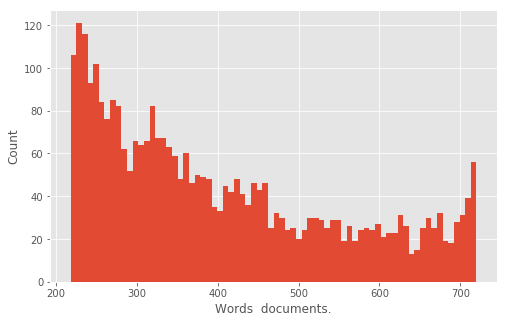

In [18]:
### DEFACTORING INSPECTION
plt.style.use('ggplot')
ax = pd.Series([x[1] for x in wordcounts.most_common(n=3200)]).hist(
    bins=72, 
    figsize=(8,5))
ax.set_xlabel("Words  documents.")
ax.set_ylabel("Count")
plt.show()

The plot above shows a histogram of the top 3,200 words and how they are expressed across corpus. The spike on the right end of this chart shows there are nearly 60 words that appear in all 720 documents (as we can see in the text table above). As a whole, the higher bars on the left side of the chart indicate most of the words appear in a smaller number of documents. Here we use defactoring as a technique to investigate and even generate intermediate representations of the data, representations implicit in the data structures created by Underwood and Sellers, but not explicitly visualized in their narrative. For our purposes, this image is an interesting chapter in the story of the data precisely because it is in the middle of Underwood and Seller’s analysis. These middle states are often glossed over in the hurried rush for analysis to generate a meaningful result. Defactoring is an effort to slow down, take a breather, and reflect upon the data-work that has happened up until this point in the code. The meandering step-by-step journey through the code sometimes reveals very interesting paths not taken, such as the commented out code block below.

In [19]:
# vocablist = binormal_select(vocablist, positivecounts, negativecounts, totalposvols, totalnegvols, 3000)
# Feature selection is deprecated. There are cool things
# we could do with feature selection,
# but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
# The tradeoff isn't worth it. Explanation is more important.
# So we just take the most common words (by number of documents containing them)
# in the whole corpus. Technically, I suppose, we could crossvalidate that as well,
# but *eyeroll*.

The author’s code above does not actually perform any work as each line has been commented out, however we include it because it points towards an execution path not taken and an interesting rationale for why it was not followed. In the “production” code the heuristic for feature selection is to simply select the 3200 most common words by their appearance in the 720 documents. This is a simple and easy technique to implement and–more importantly–explain to a literary history and digital humanities audience. Selecting the top words is a well established practice in text analysis and it has a high degree of methodologically face validity. It is a good mechanism for removing features that have diminishing returns. However, the commented code above tells a different, and methodologically significant, story.
The comment discusses an alternative technique for feature selection using binormal selection. Because this function is commented out and not used in the analysis, we have opted to not include it as part of the defactoring. Instead, we have decided to focus on the more interesting rationale about why binormal selection is not being used in the analysis as indicated in the author’s comments:

> There are cool things we could do with feature selection, but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
> The tradeoff isn't worth it. Explanation is more important.

This comment reveals much about the reasoning, the effort, and energy focused on the important, but oft neglected in the humanities, work of discussing methodology. As Underwood argued in *The literary uses of high-dimensional space* (Underwood 2015), while there is enormous potential for the application of statistical methods in humanistic fields like literary history there is resistance to these methods because there is a resistance to methodology. Underwood has described the humanities disciplines relationship to methodology as an “insistence on staging methodology as ethical struggle” (Underwood 2013) . In this commented code we can see the material manifestation of Underwood’s sentiment, in this case embodied by self-censorship in the decision to not use more statistically robust techniques for feature selection. We do not argue this choice compromises the analysis or final conclusions, rather we want to highlight the practical and material ways a resistance to plurality in research methods manifests in the digital humanities. By focusing on a close reading of the code and execution environment, by *defactoring*, we provide a methodology to assist with the omnipresent *explanatory* task commensurate with the use of computational research methods in the humanities.

In an algorithmic, data driven analysis, the selection of features is a *crucial* step because it affects the accuracy of the algorithm. In the digital humanities, feature selection is deeply embedded in the theory of the analysis and the context of the data. Claims made in and through this kind of analysis must attend to the representational configuration of the data. That is to say, we cannot take for granted how we have transformed data and what data are included or excluded from the analysis. Care, in the form of thorough documentation and thoughtful reflection, must be taken–especially at this unique moment in the development of digital humanities as we are still learning how algorithmic, data-driven techniques can be leveraged to better understand our objects of study. 

#### Filtering Authors

In [20]:
donttrainon = list()

# Here we create a list of volumed IDs not to be used for training.
# For instance, we have supplemented the dataset with volumes that
# are in the Norton but that did not actually occur in random
# sampling. We want to make predictions for these, but never use
# them for training.

for idx1, anid in enumerate(orderedIDs):
    reviewedstatus = metadict[anid]['reviewed']
    date = infer_date(metadict[anid], datetype)
    if reviewedstatus == 'addedbecausecanon':
        donttrainon.append(idx1)
    elif date < pastthreshold or date > futurethreshold:
        donttrainon.append(idx1)

As the comments describe, this block of code creates a list of volume IDs not to be used in the training. What that means *in code* is that any volume with the metadata label `addedbecauseofcanon` or with a date outside of the thresholds defined by `pastthreshold` and `futurethreshold` will be ignored. If we inspect the `donttrainon` variable we can see how many volumes satisfy these criteria.

In [21]:
### DEFACTORING INSPECTION
print("The variable donttrainon contains {} volume IDs".format(
    len(donttrainon)))

The variable donttrainon contains 0 volume IDs


It would appear there are no volumes to be filtered out by these criteria.

In [22]:
authormatches = [list(donttrainon) for x in range(len(orderedIDs))]
# For every index in authormatches, identify a set of indexes that have
# the same author. Obvs, there will always be at least one.

# Since we are going to use these indexes to exclude rows, we also add
# all the ids in donttrainon to every volume

for idx1, anid in enumerate(orderedIDs):
    thisauthor = metadict[anid]['author']
    for idx2, anotherid in enumerate(orderedIDs):
        otherauthor = metadict[anotherid]['author']
        if thisauthor == otherauthor and not idx2 in authormatches[idx1]:
            authormatches[idx1].append(idx2)

for alist in authormatches:
    alist.sort(reverse = True)

# I am reversing the order of indexes so that I can delete them from
# back to front, without changing indexes yet to be deleted.
# This will become important in the modelingprocess module.

In this block of code Underwood and Sellers group the volumes by the same author. The list `authormatches` is a list of lists for each volume. Each sub-list contains the IDS of all the volumes by the same author. Essentially this data structure represents the potential relations of each volume to other volumes, with that relation being “other volumes by the same author.” This raises the question, how many volumes share the same author in this corpus.

In [23]:
### DEFACTORING INSPECTION
# Tabular view of shared authorship
pd.Series([len(x) for x in authormatches]).value_counts()

1    579
2     82
3     30
5     15
4      8
6      6
dtype: int64

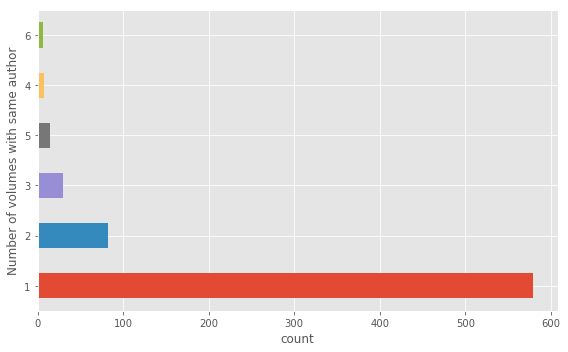

In [24]:
### DEFACTORING INSPECTION
# Barchart of shared authorship
ax = (pd.Series([len(x) for x in authormatches])
      .value_counts()
      .plot(kind="barh",
           figsize=(8,5)))
ax.set_xlabel("count")
ax.set_ylabel("Number of volumes with same author")
plt.tight_layout()

This histogram tells us a majority of volumes are written by unique authors but that there are some authors who have written up to six volumes in the corpus. Note, we are generating this graph by counting the length of the list containing the volume IDs of other volumes by the same author. This means volumes written by the same author are counted twice. This is not an issue for the purposes of our inspection, just that the sum total number of volumes represented by this histogram is greater than 720.

#### Filtering Words

In [25]:
### DEFACTORING DEFINITIONS

usedate = False
# Leave this flag false unless you plan major
# surgery to reactivate the currently-deprecated
# option to use "date" as a predictive feature.

def get_features(wordcounts, wordlist):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    return wordvec

# In an earlier version of this script, we sometimes used
# "publication date" as a feature, to see what would happen.
# In the current version, we don't. Some of the functions
# and features remain, but they are deprecated. E.g.:

def get_features_with_date(wordcounts, wordlist, date, totalcount):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords + 1)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    wordvec = wordvec / (totalcount + 0.0001)
    wordvec[numwords] = date
    return wordvec

This code cell defines two functions to be used below when opening and parsing the raw data files (in the `poems/` directory). The function `get_features()` simply takes the wordcounts from the parsed volume and filters out any words that are not part of `wordlist`, which contains the list of word features that had been selected for this analysis. We have also included a second function, `get_features_with_date()`, even though it is not executed. This residual code points to yet another path not taken, one that uses the volume’s publication date as a feature. As Underwood and Seller’s comment indicates, this was an experiment from an “earlier version of this script...to see what would happen.”

In [26]:
volsizes = dict()
voldata = list()
classvector = list()

for volid, volpath in volspresent:

    with open(volpath, encoding = 'utf-8') as f:
        voldict = dict()
        totalcount = 0
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 2 or len(fields) < 2:
                continue

            word = fields[0]
            count = int(fields[1])
            voldict[word] = count
            totalcount += count

    date = infer_date(metadict[volid], datetype)
    date = date - 1700
    if date < 0:
        date = 0

    if usedate:
        features = get_features_with_date(voldict, 
                                          vocablist, 
                                          date, 
                                          totalcount)
        voldata.append(features)
    else:
        features = get_features(voldict, vocablist)
        voldata.append(features / (totalcount + 0.001))


    volsizes[volid] = totalcount
    classflag = classdictionary[volid]
    classvector.append(classflag)
    
data = pd.DataFrame(voldata)

This is an important code block because we are now pulling the raw data files from the poems/ directory into memory, filtering out the unselected word features, and putting the data into a vectorized data structure. The code loops over the `volspresent` variable and parses each individual volume into the `voldict` dictionary. At this stage the code is reading in all the words of a volume including their frequencies, and it is tabulating the total number of words in that volume. Once all of the data for the volume has been read into memory, the code calls the `get_features` function that throws out the words not part of the selected word features stored in the `vocablist` variable. This is where the top 3200 words are foregrounded and the remaining, less commonly used words, are discarded.

At this point, any prosaic resemblance left in the data is gone and now we are dealing entirely with textual data in a numeric form.

In [27]:
### DEFACTORING INSPECTION
print("The vector representation of {} by {}".format(
    metadict[defactoring_volume_id]['title'], 
    metadict[defactoring_volume_id]['author']))
print("The vector has a length of {}.".format(
    len(features)))
print("The first 100 elements of the vector:")
print(features[0:100])

The vector representation of The croakers by Drake, Joseph Rodman,
The vector has a length of 3200.
The first 100 elements of the vector:
[ 199.  146.  885.  562.  176. 1152.  509.  195.  215.  956.  288.  156.
  215.  200.  215.  159.  149. 2043.  222.   92.  171.  457.  162.  113.
  146.  118.  335.   84.  181.   93.  102.  258.   65.  159.   79.  135.
   72.   95.   61.   70.   84.   45.   73.   40.   44.   38.   88.   35.
   73.   59.   74.  100.   76.   29.   54.   55.   40.   48.   51.   54.
   21.   58.   37.   60.   63.   34.   40.   24.   63.   55.   11.   79.
   28.   47.   21.   28.   39.   19.   15.   30.   44.   15.   23.   25.
   81.   60.   33.   17.   15.   67.   33.   55.   31.   22.   55.   26.
   35.   40.   14.  117.]


The inspection above shows us the last volume processed by the loop, The croakers by Joseph Rodman Drake. As we can see, the words for this volume of poetry are now represented as a list of numbers (representing word frequencies). However, this list of numbers still requires additional transformation in order to be consumable by logistic regression. The word frequencies need to be normalized so they are comparable across volumes. To do this Underwood and Sellers divide the frequency of each individual word (each number in the list above) by the total number of words in that volume (the `totalcount` variable. This makes volumes of different lengths comparable by turning absolute frequencies into relative frequencies. One thing we initially did not understand is why the value of 0.001 has been added to the `totalcount` variable. When we asked, it turns out this is a “lazy” way to prevent divide-by-zero errors.

The end result of the code we have executed thus far in the notebook is a very neat and tidy table of numbers between zero and 1.

In [28]:
### DEFACTORING INSPECTION
# Normalized perspective of the data
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199
715,0.006064,0.004322,0.012832,0.014809,0.005595,0.038597,0.016082,0.007203,0.003752,0.020337,...,0.000034,0.000000,0.000067,0.000000,0.000067,0.000000,0.0,0.000000,0.000034,0.000000
716,0.006234,0.004711,0.013610,0.015704,0.003997,0.045541,0.022842,0.006091,0.002379,0.020320,...,0.000048,0.000048,0.000000,0.000000,0.000143,0.000048,0.0,0.000143,0.000000,0.000048
717,0.003002,0.003458,0.020750,0.018532,0.005024,0.042088,0.009266,0.007243,0.001436,0.021403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000261
718,0.007437,0.004857,0.011535,0.011839,0.003643,0.019200,0.012370,0.004326,0.003794,0.022236,...,0.000000,0.000152,0.000076,0.000000,0.000000,0.000000,0.0,0.000076,0.000000,0.000000
719,0.004548,0.003337,0.020227,0.012845,0.004022,0.026329,0.011633,0.004457,0.004914,0.021849,...,0.000000,0.000000,0.000000,0.000023,0.000046,0.000023,0.0,0.000000,0.000000,0.000069


The last row in that table, 719, is the volume we have been tracking, The croakers by Joseph Rodman Drake. It is just one of 720 relatively indistinguishable rows of numbers in this representation of 19th century poetry. This is a radical transformation of the original, prosaic representation literary historians are probably used to seeing:

![Screenshot of the Google Books site for The Croakers](notebook_resources/the-croakers.png)

In [29]:
sextuplets = list()
for i, volid in enumerate(orderedIDs):
    listtoexclude = authormatches[i]
    asixtuple = (data, 
                 classvector, 
                 listtoexclude, 
                 i, 
                 usedate, 
                 regularization)
    sextuplets.append(asixtuple)

This is the last step before Underwood and Sellers’s code moves away from the transformation of features and into the actual analysis of the data. This bit of code gathers all of the relevant data and metadata that has been cleaned and normalized in a structure suitable for performing the statistical analysis. The `sextuplets` variable is a list of 720 tuples containing six elements. Each item in the `sextuplets` list contains the necessary data structures to model each poem. The contents of each item in the list is as follows:

- `data`: a normalized feature matrix. Word features are the columns and volumes are the rows with dimensions of 720 x 3200.
- `classvector`: the classification or labels of volumes as either 'reviewed' (1) or 'random' (0).
- `listtoexclude`: the list of poems to ignore because they are the same author.
- ``i: the index of the volume
- `usedate`: a flag indicating if date is a feature. It is false in this analysis.
- `regularization`: a parameter for the logistic regression. This value was hardcoded at the beginning of the code in the Setting Parameters section.

With all of the data assembled and in the right shape, a process we call *data fitness*, we can now venture into the algorithmic territory and perform the statistical analysis. As we can see, the *fitted* representation of features has traveled a great distance from the original poetry. One of the most important aspects of *distant reading* is the work of cleaning, preparing, and normalizing texts to be "read" by an algorithm. When considering distance, we should think not only of the perspective that we, the analyst, are reading from, but also the distance traveled in terms of successive transformations and representations of the data. If computational literary history is a triathalon, we have only completed the first endurance test.

### Training Predictive Models

We are now about to dive into the very heart of the analysis, training predictive models on each volume. The code cells below do the following:


- Iterate over every volume in the corpus. For each volume, do the following:
    - Create a training set by removing the selected volume and other volumes by the same author from the corpus (performed by the `sliceframe()` function). In the language of predictive modeling, the removed volume is the “held out” data.
    - Normalize the training data by computing the z-score for each feature/feature set (performed by the `normalizearray()` function).
    - Fit the model on the training data (performed by the `model_one_volume()` function).
    - Use the fitted model to predict the probability the (normalized) held out data was "reviewed" or "random."
    
What is important to understand is that this section of the code does not train a single model, rather it trains 720 independent models–one for each volume. This process is called “leave-one-out” cross validation. As the code loops over the volumes, it holds out one volume, trains the model on all of the remaining volumes, and then uses that model to predict the status of the held out volume. Lather, Rinse, Repeat.

In [30]:
### DEFACTORING DEFINITION

def sliceframe(dataframe, yvals, excludedrows, testrow):
    numrows = len(dataframe)
    newyvals = list(yvals)
    for i in excludedrows:
        del newyvals[i]
        # NB: This only works if we assume that excluded rows
        # has already been sorted in descending order !!!!!!!
        # otherwise indexes will slide around as you delete

    trainingset = dataframe.drop(dataframe.index[excludedrows])

    newyvals = np.array(newyvals)
    testset = dataframe.iloc[testrow]

    return trainingset, newyvals, testset

This function prepares the data for training one model by separating volumes used for training from a single volume held out to test the predictive power of the model. The function takes a dataframe containing the feature vectors, a list of the classifications for each volume, a list of volumes to exclude(because of shared authorship), and the the index of the specific volume to be held out. It returns the dataframe with the held out volume removed (`trainingset`), a list of the known classifications (`newyvals`) corresponding to the training set, and the held-out volume that will be classified once the model has been trained (`testset`).

In [31]:
### DEFACTORING DEFINITION

def normalizearray(featurearray, usedate):
    '''Normalizes an array by centering on means and
    scaling by standard deviations. Also returns the
    means and standard deviations for features.
    '''

    numinstances, numfeatures = featurearray.shape
    means = list()
    stdevs = list()
    lastcolumn = numfeatures - 1
    for featureidx in range(numfeatures):

        thiscolumn = featurearray.iloc[ : , featureidx]
        thismean = np.mean(thiscolumn)

        thisstdev = np.std(thiscolumn)

        if (not usedate) or featureidx != lastcolumn:
            # If we're using date we don't normalize the last column.
            means.append(thismean)
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
        else:
            print('FLAG')
            means.append(thismean)
            thisstdev = 0.1
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
            # We set a small stdev for date.

    return featurearray, means, stdevs

This function standardizes the features by computing the z-score for the feature vectors. That is, it loops over each each column of the data, subtracts the column mean from each value, and then divides that value by the standard deviation. This is an important step in the data preparation pipeline because it ensures all of the data values are on the same scale.

In [32]:
### DEFACTORING DEFINITION

def model_one_volume(data5tuple):
    data, classvector, listtoexclude, i, usedate, regularization = \
        data5tuple
    trainingset, yvals, testset = sliceframe(data, 
                                             classvector, 
                                             listtoexclude, 
                                             i)
    newmodel = LogisticRegression(C = regularization)
    trainingset, means, stdevs = normalizearray(trainingset, usedate)
    newmodel.fit(trainingset, yvals)

    testset = (testset - means) / stdevs
    prediction = newmodel.predict_proba(testset.values.reshape(1, -1))[0][1]
    if i % 50 == 0:
        print(i)
    # print(str(i) + "  -  " + str(len(listtoexclude)))
    return prediction

In many respects, this is the most salient block of code in the entire document. The code above actually runs the logistic regression and does the algorithmic work that generates a prediction about each individual volume. This function builds upon the two previous functions to assemble a normalized set of training data (`trainingset`) distinct from the single volume to be predicted (`testset`).

There are three lines of code involved in the computational modeling of the data. First, Underwood and Sellers instantiate a model object with the regularization parameter (more on that below):
```
newmodel = LogisticRegression(C = regularization)
```
Then they “fit” the model using the normalized training data:
```
newmodel.fit(trainingset, yvals)
```
Once a model has been “fit” to the data they can use that model to make predictions about unseen or held-out data. This is what they do with the predict_proba() function in this line:
```
prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1]
```
Those three lines are all it takes to do the computational part of of the analysis, the rest of the code up until this point has all been data preparation, cleaning, normalization, and re-shaping. This ratio of analytical to preparative code is interesting and indicates that claims that machines are eradicating scholars’ jobs are greatly exaggerated (Basken 2017).

#### Regularization and Logistic Regression

The three lines of code above hide a significant amount of intellectual and computational work. The call to the newmodel.fit() function is a crucial step in the analytical process. Underwood and Sellers are using an implementation of Logistic Regression from the 3rd party Python library scikit-learn.

At a very high level, logistic regression is a machine learning algorithm for performing classification. Logistic regression works by estimating the parameters of a function, the *hypothesis representation*, that divides a multidimensional space into two parts (note, in this case we are talking about binomial or binary logistic regression, which classifies things into one of two bins). The hypothesis representation describes a line that winds its way through the space creating what is called the *decision boundary*. Every data point that lands on one side the boundary gets one label and every data point on the other side of the boundary gets the other label. Similar to linear regression, the goal is to find the best hypothesis representation, that is, the function that best draws a line dividing the space given the known data points. Once you have a good hypothesis representation, an appropriately *fit* model, you can begin to classify *new* data by dropping data points into the multidimensional space and seeing on which side of the decision boundary they land.

The key to logistic regression is estimating the parameters of the hypothesis representation–the parameters to the function that draws a line through the multidimensional space. We can derive the parameters by using the *features* of existing data combined with their known labels; this is called *training data*. The modeling process is executed by the function call to newmodel.fit(trainingset, yvals). In Underwood and Sellers’s code the model uses the training data—the matrix of word features in the data variable and known labels (‘reviewed’ or ‘random’) in the classvector variable—to “learn” the parameters through a process called *coordinate descent*. How so-called optimization functions  work is well beyond the scope of the discussion.

#### Overfitting

One of the problems when fitting a logistic regression model is a tendency towards *overfitting*. Crudely this means the model, the function with the learned parameters, that you estimated have tailored themselves such that they are overly optimized to the particular training data you provided. As such, the model becomes less useful for prediction or classifying new data because they are outside the fitness of the model. An overfit model is like a snug pair of jeans, once you put on a few pounds (add new data) they don’t fit. In Underwood and Sellers’s case, they are fitting models on all volumes except one, which is held out. Then they test the predictive performance of the model by seeing if it correctly classifies the held-out volume. If they overfit the models, the model will to a terrible job guessing the status of the held out volumes.

When Underwood and Sellers instantiated the model (newmodel = LogisticRegression(C = regularization)), they set a regularization parameter on the model. Regularization is a technique for logistic regression (and other machine learning algorithms) that smooths out the tendency toward overfitting with some more mathematical gymnastics. The diagram below shows how regularization can help with the fitness of the model:

![Regularization](notebook_resources/regression_figures.png)
*On the left side is a linear regression which doesn’t quite fit the data. In the middle is an overfit logistic regression. On right side is a regularized logistic regression.*

As the diagrams show, the regularized logistic expression (the right side) does have a bit of error, there are pink and blue dots on the wrong sides of the decision boundary, but as more data get added it will generally be more right than the overfitted model as represented by the middle diagram (the squiggly decision boundary).

#### Running the Regression

In [33]:
# Now do leave-one-out predictions.
print('Beginning multiprocessing.')

pool = Pool(processes = 4)
res = pool.map_async(model_one_volume, sextuplets)

# After all files are processed, write metadata, errorlog, and counts of phrases.
res.wait()
resultlist = res.get()

assert len(resultlist) == len(orderedIDs)

logisticpredictions = dict()
for i, volid in enumerate(orderedIDs):
    logisticpredictions[volid] = resultlist[i]

pool.close()
pool.join()

print('Multiprocessing concluded.')

Beginning multiprocessing.
0
50
100
150
200
250
300
350
450
500
400
550
600
650
700
Multiprocessing concluded.


This code automates the training of 720 volumes, holding out one volume, training the model on the remaining volumes, and then making a prediction the held out volume.  As a very computation intensive process training or fitting a logistic regression model takes time, and training 720 different models obviously takes 720 times longer. Fortunately, this is a so called embarrassingly parallel computational task and so we can train the models using parallel processing instead of one after the other. Using Python’s built in parallel processing modules, this code can speed up the process. Still, this block of code takes a fair amount of time to execute, around twenty minutes on a quad core MacBook Pro (late 2013 model). 

In [34]:
### DEFACTORING INSPECTION
print("There are {} predictions.".format(len(logisticpredictions)))


There are 720 predictions.


What emerges from the other side of this computationally intensive task are a series of predictions, 720 to be specific, one for each of the modeled volumes. These predictions, stored in the `logisticpredictions` variable, are the model’s assertions of each volume’s reviewed status. Additionally, because we already know the status of the modeled volumes we can compare the performance of the predictive model to the “ground truth” and see if the algorithm was able to detect patterns.

In [35]:
truepositives = 0
truenegatives = 0
falsepositives = 0
falsenegatives = 0
allvolumes = list()

with open(outputpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['volid', 
              'reviewed', 
              'obscure', 
              'pubdate', 
              'birthdate', 
              'gender', 
              'nation', 
              'allwords', 
              'logistic', 
              'author', 
              'title', 
              'pubname', 
              'actually', 
              'realclass']
    writer.writerow(header)
    for volid in IDsToUse:
        metadata = metadict[volid]
        reviewed = metadata['reviewed']
        obscure = metadata['obscure']
        pubdate = infer_date(metadata, datetype)
        birthdate = metadata['birthdate']
        gender = metadata['gender']
        nation = metadata['nation']
        author = metadata['author']
        title = metadata['title']
        canonicity = metadata['canonicity']
        pubname = metadata['pubname']
        allwords = volsizes[volid]
        logistic = logisticpredictions[volid]
        realclass = classdictionary[volid]
        outrow = [volid, 
                  reviewed, 
                  obscure, 
                  pubdate,
                  birthdate, 
                  gender, 
                  nation, 
                  allwords, 
                  logistic, 
                  author, 
                  title, 
                  pubname, 
                  canonicity, 
                  realclass]
        writer.writerow(outrow)
        allvolumes.append(outrow)

        if logistic > 0.5 and classdictionary[volid] > 0.5:
            truepositives += 1
        elif logistic <= 0.5 and classdictionary[volid] < 0.5:
            truenegatives += 1
        elif logistic <= 0.5 and classdictionary[volid] > 0.5:
            falsenegatives += 1
        elif logistic > 0.5 and classdictionary[volid] < 0.5:
            falsepositives += 1

This code is a bit simpler than its predecessors. This block writes a CSV file to disk containing 720 rows of volume metadata, the predicted classification, and the actual classification.  

### Modeling Coefficients

The code below generates a single logistic regression model, trained on all of the data with nothing held-out. The properties of this model, the coefficients of the hypothesis representation, are interrogated to better understand the influence of individual features, words, on reviewed or unreviewed volumes. Thus this individual model is not using computational modeling to predict a phenomena, it is using the computational model to explore and explain patterns and features of the phenomena.

In [36]:
donttrainon.sort(reverse = True)
trainingset, yvals, testset = sliceframe(data, 
                                         classvector, 
                                         donttrainon, 
                                         0)
newmodel = LogisticRegression(C = regularization)
trainingset, means, stdevs = normalizearray(trainingset, usedate)
newmodel.fit(trainingset, yvals)

coefficients = newmodel.coef_[0] * 100

coefficientuples = list(zip(coefficients, 
                            (coefficients / np.array(stdevs)), 
                            vocablist + ['pub.date']))
coefficientuples.sort()
if verbose:
    for coefficient, normalizedcoef, word in coefficientuples:
        print(word + " :  " + str(coefficient))

print()
accuracy = (truepositives + truenegatives) / len(IDsToUse)

This code functions much like the code in the `model_one_volume(`) function except it only trains a single model for the purposes of investigating the the impact of particular words on the prediction. By inspecting the magnitude of the coefficients Underwood and Sellers can see how particular words influenced a positive or negative prediction. Looking at the code, specifically the call to `sliceframe()` reveals this model actually does have some hold-out data, the first volume at index zero. We suspect the cost of excluding a single volume is less than the effort of re-implementing the `sliceframe()` function. The code to instantiate and train the model is identical to the code above, but instead of predicting the status of the held-out data the code extracts the coefficients from the model and puts them in the `coefficients` variable.

In [37]:
### DEFACTORING INSPECTION
print("There are {} coefficients in this model.".format(len(coefficientuples)))

There are 3200 coefficients in this model.


In [38]:
### DEFACTORING INSPECTION
print("First ten items in the list of coefficients.")
coefficientuples[:10]

First ten items in the list of coefficients.


[(-0.451744515308058, -1531.5503056343666, "i'll"),
 (-0.42711374653208284, -7254.811741867888, 'mission'),
 (-0.4116879738928419, -862.7068493207225, 'tis'),
 (-0.37939299320003567, -1125.1778023608326, 'oft'),
 (-0.3783134051280357, -3337.335314702983, 'greet'),
 (-0.37399562365121103, -2558.9492503627807, 'wondrous'),
 (-0.3712630706903529, -222.8852087160384, 'our'),
 (-0.3695437312947107, -4356.707179481598, 'anxious'),
 (-0.35904965455922144, -2087.1252362010537, 'cheer'),
 (-0.35632804949908553, -1383.450564130784, "we'll")]

In [39]:
### DEFACTORING INSPECTION
print("Last ten items in the list of coefficients.")
coefficientuples[-10:]

Last ten items in the list of coefficients.


[(0.3726635222640156, 4799.590619119897, 'brows'),
 (0.381170570302538, 224.41690606199722, 'not'),
 (0.3825388340735533, 1149.152152033426, 'half'),
 (0.38439578227360166, 398.793247462678, 'what'),
 (0.38473402074228275, 6977.874918531145, 'whereon'),
 (0.39921722974326485, 3171.5809993565736, 'sake'),
 (0.403144385914046, 2023.7759161873807, 'slow'),
 (0.40674741624813554, 3933.908677099459, 'hollow'),
 (0.41261956910143927, 1531.930520538605, 'black'),
 (0.4525125027699761, 615.0067489318402, 'eyes')]

The coefficients are a list of numbers, one per word feature, that determine the shape of the line through the multidimensional space. These results tell us the influence of particular words in the classification of volumes in the corpus. Looking at the normalized values helps us understand the degree to which particular words are more or less associated with reviewed or unreviewed poetry.

In [40]:
coefficientpath = outputpath.replace('.csv', '.coefs.csv')
with open(coefficientpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    for triple in coefficientuples:
        coef, normalizedcoef, word = triple
        writer.writerow([word, coef, normalizedcoef])


### DEFACTORING NAMESPACE
rawaccuracy = accuracy 

This code generates the `mainmodelcoefficients.csv` output file, which contains the word, its coefficient, and its normalized coefficients.

### Plotting Results

The final function of the analysis is to test the accuracy of the model(s). This code produces a plot giving a sense of how the model performed compared to the known classifications.

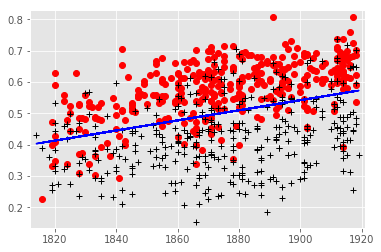

If we divide the dataset with a horizontal line at 0.5, accuracy is:  0.7736111111111111
Divided with a line fit to the data trend, it's  0.7916666666666666


In [41]:
### DEFACTORING FUNCTION PARAMETERS
modeltype = 'linear'
datelimits = []
''' Takes a set of predictions produced by a model that knows nothing about date,
and divides it along a line with a diachronic tilt. We need to do this in a way
that doesn't violate crossvalidation. I.e., we shouldn't "know" anything
that the model didn't know. We tried a couple of different ways to do this, but
the simplest and actually most reliable is to divide the whole dataset along a
linear central trend line for the data!
'''



listofrows = list()
classvector = list()

# DEPRECATED
# if modeltype == 'logistic' and len(datelimits) == 2:
#     # In this case we construct a subset of data to model on.
#     tomodeldata = list()
#     tomodelclasses = list()
#     pastthreshold, futurethreshold = datelimits

for volume in allvolumes:
    date = volume[3]
    logistic = volume[8]
    realclass = volume[13]
    listofrows.append([logistic, date])
    classvector.append(realclass)

    # DEPRECATED
    # if modeltype == 'logistic' and len(datelimits) == 2:
    #     if date >= pastthreshold and date <= futurethreshold:
    #         tomodeldata.append([logistic, date])
    #         tomodelclasses.append(realclass)

y, x = [a for a in zip(*listofrows)]
plt.axis([min(x) - 2, max(x) + 2, min(y) - 0.02, max(y) + 0.02])
reviewedx = list()
reviewedy = list()
randomx = list()
randomy = list()

for idx, reviewcode in enumerate(classvector):
    if reviewcode == 1:
        reviewedx.append(x[idx])
        reviewedy.append(y[idx])
    else:
        randomx.append(x[idx])
        randomy.append(y[idx])

plt.plot(reviewedx, reviewedy, 'ro')
plt.plot(randomx, randomy, 'k+')

if modeltype == 'logistic':
    # all this is DEPRECATED
    print("Hey, you're attempting to use the logistic-tilt option")
    print("that we deactivated. Go in and uncomment the code.")

    # if len(datelimits) == 2:
    #     data = pd.DataFrame(tomodeldata)
    #     responsevariable = tomodelclasses
    # else:
    #     data = pd.DataFrame(listofrows)
    #     responsevariable = classvector

    # newmodel = LogisticRegression(C = 100000)
    # newmodel.fit(data, responsevariable)
    # coefficients = newmodel.coef_[0]

    # intercept = newmodel.intercept_[0] / (-coefficients[0])
    # slope = coefficients[1] / (-coefficients[0])

    # p = np.poly1d([slope, intercept])

elif modeltype == 'linear':
    # what we actually do

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope = z[0]
    intercept = z[1]

plt.plot(x,p(x),"b-")
plt.show(block = False)

x = np.array(x, dtype='float64')
y = np.array(y, dtype='float64')
classvector = np.array(classvector)
dividingline = intercept + (x * slope)
predicted_as_reviewed = (y > dividingline)
really_reviewed = (classvector == 1)

accuracy = sum(predicted_as_reviewed == really_reviewed) / len(classvector)

### DEFACTORING NAMESPACE
tiltaccuracy = accuracy 

print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', 
      str(rawaccuracy))

print("Divided with a line fit to the data trend, it's ", 
      str(tiltaccuracy))

The code above generates a best fit line for all of the results. Underwood and Sellers then selects the predicted-as-reviewed volumes, which are the volumes falling above the dividing line. The accuracy of the dividing line is the ratio between the total number of volumes predicted-as-reviewed and the number of actually reviewed volumes. Note that this is the accuracy of the dividing line, not the accuracy of the model(s) to predict the reviewed status of the poems.

## Discussion & Conclusion

The story told by *defactoring pace of change* is one of data transformation made material through an exhaustive, line-by-line, reading *and execution* of the bespoke code used in Underwood and Sellers's historical literary analysis. *Code is the engine of intermediate representation.* What we mean by this is the computational narrative told by Pace of Change is one of transformations. Transformation of data (and metadata) into new data. Code is the material documentation, the record, the residue of these transformations. But code, when executed, is also the engine of these transformations.

### Representations of Data In and Through Code

From the perspective of data, Pace of Change doesn’t start at the beginning, the project begins with a collection of data and metadata that came from somewhere, they are not “raw” but had already been “cooked” to an extant from poetry volumes into bags of words (Underwood 2014). There is a significant amount of “data-work” done even before Pace of Change begins, but like the layers of code in the form of shared libraries, operating systems, and general purposes programming languages, this data-work is not bespoke to Pace of Change. We can think of this data-work as happening at different layers similar to Hinsen’s layers of scientific software. Both the data and code included in the Pace of Change GitHub repository are products derived from or leveraging larger “libraries” (both in the sense of software libraries like scikit-learn and digital libraries like HathiTrust). Defactoring can use the same selection heuristic for code as for data; only the bespoke data and code are the subject of our investigation. The OCR’d texts in the HathiTrust digital library are akin to the general purpose programming languages or operating systems in that they can be used for many purposes. While the content and context of the data before the Pace of Change analysis are salient and important, others have been attending to those stories (Chalmers and Edwards 2017). The focus of defactoring is the intimate relationship between the data, the code, and the execution environment within which the representational work of computational research occurs. What defactoring reveals about that relationship is that bespoke data *seems to be a verb.*

The data in Pace of Change are not one thing, but rather a series of interconnected things. The story of the data, as told through the code, is a series of temporary representations created, manipulated, and destroyed in the computational analysis process. The data in Pace of Change starts as a tabular collection of metadata and a collection of bags of words. The code filters and cleans metadata creating a Python data structure with a subset of the data (mostly) relevant to the analysis. The selected metadata then drives the processing of the data files, the bags of words, to select a subset of those data, the top 3,200 word features, and to create vector representations for each poetry volume and their associated status as reviewed or not reviewed. Once transformed into normalized, numeric feature vectors (the "features matrix" in machine learning terminology) and a vector of binary labels (the "target array" in machine learning terminology). Much of the bespoke code-work of Pace of Change is in the service of producing these two representations of the data (as is much of the work in most data and computational research). Bespoke code for transforming bespoke data into standardized representations of data conformant to standardized software, in this case the scikit-learn API (Buitinck 2013) and the logistic regression. What comes out the other side of the most mathematically intensive transformation of Pace of Change is *more* data, but these data are qualitatively and quantitatively different because they are inoculated with new insights about the data they represent. The predictions of 720 individual statistical models for each poetry volume and the coefficients of final statistical model are, for Underwood and Sellers, the important representation for it is through the interpretation of these representations can they find new insights about literary history. This interpretation work is, of course, done through code that produces a data visualization (because charts surpass data tables in their comprehensibility and rhetorical power). The data story of the Pace of Change code ends with a chart and two new CSV files. One could, theoretically, review and critique these data, but we would argue, focusing on just the data in absence of the code by which they are made manifest would only be a small part of the story.


### What defactoring as a method helps us understand

There is a tendency both in scholars and engineers to separate things (Bowker and Star 1999; https://en.wikipedia.org/wiki/Separation_of_concerns). We can see one such separation in one of the largest community of digital praxis in the humanities, the TEI-XML movement. Inspired by early developments in electronic typesetting (Goldfarb 1996) both textual scholars and engineers arrived upon the idea of separation of form and content (DeRose et al. 1990): there is the textual information (“Nixon resigns”), and there is how that information looks (e.g. bold large caps in the case of a newspaper heading). Thus in TEI-XML an unproblematic separation of information and layout is assumed. On closer inspection however, such a separation is not as unproblematic at all (Welch 2010, Galey 2010). Form demands to be part of meaning and interpretation as is dramatically clear from looking at just one poem by William Blake. Yet such separation has emerged in science and research: data tends to be separated from research as an analytical process, and the creation of digital research objects (such as digital data and analytic code) goes often unrecognised as intellectual research work and is considered ‘mere’ supportive material labor (Burgess and Hamming, 2011). Data is mostly regarded as a neutral and research independent entity, indeed something ‘given’ as the Latin root suggests. That the state of data are not quite as straightforward has been argued before (Galey 2010, Drucker 2011, and Gitelman 2013). From our defactoring experience we derive the same finding; there are rich stories to tell about the interactions between code and data. 

Code can be read and reviewed independant of its context and purpose, as a static textual object. In such a case one looks critically at the structure of the code (are separate steps of the process clearly delineated and pushed to individual subroutines to create a clearly articulated and maintainable process, are there considerable performance issues, have existing proven libraries been used). This kind of criticism—we could compare it to textual criticism—is informative but in a way that is wholly unconnected to the context of its execution. It is like picking apart every single cog in a mechanical clock to judge if it is well built, but without being interested in what context and for what purpose it will tell time. This would be code review or code peer review, as practiced in an industrial setting. Code peer review takes the structural and technical quality of code into consideration only insofar that obvious analytical errors should be pointed out, judged against measures of performance and industrial scalability and maintainability. However, this approach has little relevance for the bespoke code of scholarly productions (level four of scientific software Hinsen’s distinction once again), it is relatively “okay for academic code to suck” as compared to the best practices of industrial code-work. But what about best practices for the bespoke code of scholarly research? What about code that "only runs once" and whose purpose is insight, not software? We put forth defactoring as a technique for unveiling bespoke code to the scholarly peer-reviewer (and potential a larger audience) the interaction between code and the content, the data, the subject matter. Essentially, we think, defactoring and code peer review should critique those moments of interaction, it is there that data, analytic code, and subject matter co-exist in some meaningful dynamic. It is at these point that code peer review—not unlike literary criticism—should ask: what happens here and what does that mean? This is where defactoring contributes to peer review. Whereas the original code is mere supportive materials, the defactored integrated into a first-order computational narrative that elevates the documentary residue of the computational analysis. 

On an epistemological level then once again it appears that we cannot carve up research in neatly containerized independent activities of which the individual quality can be easily established and aggregated to a sum that is greater than the parts. The ‘greater’ is exactly in the relations that exist between the various activities and that become opaque if the focus is put on what is inside the different containers. This is why we would push even farther than saying that data and code are not unproblematically separable entities. Indeed we would argue that they are both intrinsical parts of a grander story that Underwood and Sellers tell us and which consists of several intertwined narratives: there is a narrative that is told by the code, one that is told by the comments we found in that code, there is a narrative of data transformations. These narratives together become the premises of an overarching narrative that results first as a Figshare contribution, and later as an MLQ publication. These narratives are all stacked turtles, and they all deserve proper introspection. Quite logically with each stacked narrative the contribution of each underlying narrative becomes a little more opaque. The MLQ article suggests an unproblematic, neat, and polished process of question-data-analysis-result. But it is only thanks to their open science like attitude that Underwood and Sellers grant us insight into the very process that led from data mongering and structuring through several iterations of analysis to a presentable result. Underwood and Sellers went through several iterations of refining their story. The Figshare contribution and the code give us much insight in what the real research looked like for which the MLQ article, in agreement with Jon Claerbout's ideas (Buckheit and Donoho 1995), turns out to be a mere advertising of the underlying scholarship. In contrast to what we argue here—that data and code deserve more exposure and evaluation as being integral parts of a research narrative—we observed in the succession of narrative transformations that the research by Underwood and Sellers went through that the aspect and contribution of code became not only more opaque with every stacked narrative, but virtually disappeared altogether from the MLQ article. This is a relevant methodological aspect, as the ‘binormal_select()’ case shows. Underwood and Sellers chose not to use a more robust method for feature selection because they foresaw that the improved accuracy would not measure up to the effort required to explain it to an audience unfamiliar with more advanced statistics. There is a clear tension between the techniques being used and the explanation that must accompany them. From the comments in the code we can infer that at that point in time these research design issues were still relevant and the decision to go hither or whither hinged not only on which method would technically be better. Similarly in the MLQ publication and the Figshare contribution we find many allusions to the tweaking of the models that Underwood and Sellers used, but for which we do not find the full code anymore—for instance where they refer to including gender as a feature (2016:338) and to using multi period models (2016:329). Traces remain of these additional analyses in the code, but supplanted by later code and workflows these statistical wanderings are not explicitly documented anymore.

In all this means that there is a lot of analysis and code-work that remains unrepresented. Even in a radically open project such as Pace of Change, there is still going to be code, data, and interpretivie prose that does not make the final cut (i.e the MLQ article). Moreover, much analytic and code effort remains also invisible because it does not make the “making of documentary” that the final codebase could be regarded as, not leaving more than the odd trace, and left uninvestigated in a defactoring like ours. 

The invisibility of so many parts of the research narrative and effort signals to us again the very need for peer review that engages with the code level of research. Only by such deep and intimate code level peer review we can uncover and merit the full analytical effort that scholars undertake in computational explorations. The insights that such code level peer review yields are in our opinion relevant to development of methodology, techniques, and eventually also training.

Exploring the process of defactoring taught us again that it is impossible to take data out of its analytical context without veritably rendering it meaningless. It is the context of code and argument that co-creates interpretation and meaning from data. Cultural Analytical insights are composed of three parts: the narrative, the data, and the code. We contend that you cannot evaluate, review, or critique the argument without attending to all three of these parts. Currently that seems a rather intractable goal, if it were only for the few scholars having the required skills, but also because publication platforms are still nascent (e.g. Jupyter Notebook) and the scholarly publishing infrastructure to support them is non existent. However, we hope to have put forth defactoring as a step towards reaching that ideal.

## References

  Anderson, Steve, and Tara McPherson. 2011. “Engaging Digital Scholarship: Thoughts on Evaluating Multimedia Scholarship.” *Profession*, 136–151. https://doi.org/prof.2011.2011.1.136.
  
  Andrews, Tara L. 2012. “The Third Way: Philology and Critical Edition in the Digital Age.” *Variants* 10: 61–76. https://www.academia.edu/attachments/30526561/download_file.
  
  Antonijević, Smiljana. 2015. *Amongst Digital Humanists: An Ethnographic Study of Digital Knowledge Production*. Palgrave Macmillan.
  
  Baldridge, Jason. 2015. “It’s Okay for Academic Software to Suck.” Personal Blog. *Java Code Geeks* (blog). May 12, 2015. https://www.javacodegeeks.com/2015/05/its-okay-for-academic-software-to-suck.html.
  
  Basken, Paul. 2017. “Job-Killing Computerization Sets Its Sights on the University Researcher.” *The Chronicle of Higher Education*, February 20, 2017, sec. Research. https://www.chronicle.com/article/Job-Killing-Computerization/239248.
  
  Berry, David M. 2014. *Critical Theory and the Digital*. Critical Theory and Contemporary Society. New York, London, New Delhi etc.: Bloomsbury Academic.
  
  Betti, Arianna. 2015. *Against Facts*. Cambridge Massachusetts, London England: MIT Press.
  
  Bostrom, Nick. 2016. *Superintelligence: Paths, Dangers, Strategies*. Oxford: Oxford University Press.
  
  Bowker, Geoffrey C., and Susan Leigh Star. 1999. *Sorting Things Out: Classification and Its Consequences*. Cambridge, Massachusetts; London, England: The MIT Press.
  
  Braithwaite, Reginald. 2013. “Defactoring.” Personal Blog/Repository of Essays. *Reginald Braithwaite: Via Raganwald.Com* (blog). 2013. http://raganwald.com/2013/10/08/defactoring.html.
  
  Broadwell, P., and Timothy R. Tangherlini. 2012. “TrollFinder: Geo-Semantic Exploration of a Very Large Corpus of Danish Folklore.” In *Proceedings of LREC*. Istanbul, Turkey.
  
  Buitinck, L., G. Louppe, M. Blondel, F. Pedregosa, A. Mueller, O. Grisel, V. Niculae, et al. 2013. “API Design for Machine Learning Software: Experiences from the Scikit-Learn Project.” *ArXiv E-Prints*, September. https://arxiv.org/abs/1309.0238.

  Buckheit, J., and D.L. Donoho. 1995. “Wavelab and Reproducible Research.” In *Wavelets and Statistics*, edited by A. Antoniadis, 55–81. New York, NY: Springer. https://statweb.stanford.edu/~wavelab/Wavelab_850/wavelab.pdf.
  
  Burgess, Helen J., and Jeanne Hamming. 2011. “New Media in Academy: Labor and the Production of Knowledge in Scholarly Multimedia.” *DHQ: Digital Humanities Quarterly* 5 (3). http://digitalhumanities.org/dhq/vol/5/3/000102/000102.html.
  
  Cerquiglini, Bernard. 1999. *In Praise of the Variant: A Critical History of Philology*. Baltimore: The Johns Hopkins University Press.
  
  Chalmers, Melissa K., and Paul N. Edwards. 2017. “Producing ‘One Vast Index’: Google Book Search as an Algorithmic System.” *Big Data &amp; Society* 4 (2). https://doi.org/10.1177/2053951717716950.
  
  Clement, Tanya E. 2016. “Where Is Methodology in Digital Humanities?” In *Debates in the Digital Humanities 2016*, 153–75. University of Minnesota Press. http://dhdebates.gc.cuny.edu/debates/text/65.
  
  Dalen-Oskam, Karina van, and Joris J. van Zundert. 2007. “Delta for Middle Dutch: Author and Copyist Distinction in ‘Walewein.’” *Literary and Linguistic Computing* 22 (3): 345–362. https://doi.org/10.1093/llc/fqm012.
  
  DeRose, Steven J., David G. Durand, Elli Mylonas, and Allen H. Renear. 1990. “What Is Text, Really?” *Journal of Computing in Higher Education* 1 (2): 3–26.
  
  Drucker, Johanna. 2011. “Humanities Approaches to Graphical Display.” *Digital Humanities Quarterly* 5 (1). http://digitalhumanities.org/dhq/vol/5/1/000091/000091.html.
  
  Enderle, Jonathan Scott. 2016. “A Plot of Brownian Noise.” GitHub Personal Code Repository. *Jonathan Scott Enderle* (blog). July 18, 2016. https://github.com/senderle/svd-noise/blob/master/Noise.ipynb.
  
  Enderle, Scott. 2015. “What’s a Sine Wave of Sentiment?” Personal Blog. *The Frame of Lagado* (blog). April 2, 2015. http://www.lagado.name/blog/sine-of-the-times/.
  
  Ford, Paul. 2015. “What Is Code?” *Businessweek*, June 11, 2015. http://www.bloomberg.com/graphics/2015-paul-ford-what-is-code/.
  
  Frabetti, Federica. 2012. “Have the Humanities Always Been Digital?” In *Understanding Digital Humanities*, 161–171. London; New York: Palgrave Macmillan.

  Galey, Alan. 2010. “The Human Presence in Digital Artifacts.” In *Text and Genre in Reconstruction: Effects of Digitalization on Ideas, Behaviors, Products and Institutions*, edited by Willard McCarty, 93–118. Cambridge (UK): Open Book Publishers. http://individual.utoronto.ca/alangaley/files/publications/Galey_Human.pdf.
  
  Gitelman, Lisa, ed. 2013. *“Raw Data” Is an Oxymoron*. Cambridge (MA), USA: The MIT Press.
  
  Goldfarb, Charles F. 1996. “The Roots of SGML -- A Personal Recollection.” 1996. http://www.sgmlsource.com/history/roots.htm.
  
  Grusin, Richard. 1994. “What Is an Electronic Author? Theory and the Technological Fallacy.” *Configurations* 2 (3): 469–83. https://doi.org/10.1353/con.1994.0039.
  
  Hiller, Moritz. 2015. “Signs o’ the Times: The Software of Philology and a Philology of Software.” *Digital Culture and Society* 1 (1): 152–163. https://doi.org/10.14361/dcs-2015-0110.
  
  Hinsen, Konrad. 2017. “Sustainable Software and Reproducible Research: Dealing with Software Collapse.” Personal Academic Blog. *Konrad Hinsen’s Blog* (blog). January 13, 2017. http://blog.khinsen.net/posts/2017/01/13/sustainable-software-and-reproducible-research-dealing-with-software-collapse/.
  
  Jockers, Matthew L. 2013. *Macroanalysis: Digital Methods and Literary History*. Urabana, Chicago, Springfield: UI Press.
  
  ———. 2014. “A Novel Method for Detecting Plot.” *Matthew L. Jockers* (blog). June 5, 2014. http://www.matthewjockers.net/2014/06/05/a-novel-method-for-detecting-plot/#note1.
  
  ———. 2015. “Revealing Sentiment and Plot Arcs with the Syuzhet Package.” *Matthew L. Jockers* (blog). February 2, 2015. http://www.matthewjockers.net/2015/02/02/syuzhet/.
  
  Jones, Steven E. 2014. *The Emergence of the Digital Humanities*. New York, London: Routledge.
  
  ———. 2016. *Roberto Busa, S.J., and the Emergence of Humanities Computing: The Priest and the Punched Cards*. New York, London: Routledge, Taylor &amp; Francis Group.
  
  Kay, Alan C. 1993. “The Early History of Smalltalk.” *ACM SIGPLAN Notices* 28 (3): 69–95. https://doi.org/10.1145/155360.155364.
  
  Kestemont, M., S. Moens, and J. Deploige. 2015. “Collaborative Authorship in the Twelfth Century: A Stylometric Study of Hildegard of Bingen and Guibert of Gembloux.” *Literary and Linguistic Computing* 30 (2): 199–224. https://doi.org/10.1093/LLC/FQT063.
  
  Kestemont, Mike, Guy de Pauw, Renske van Nie, and Walter Daelemans. 2017. “Lemmatization for Variation-Rich Languages Using Deep Learning.” *Digital Scholarship in the Humanities* 32 (4): 797–815. https://doi.org/10.1093/llc/fqw034.
  
  Kittler, Friedrich. 1993. “Es gibt keine Software.” In *Draculas Vermächtmis*, 225–242. Leipzig: Reclam Verlag.
  
  Knuth, Donald E. 1984. “Literate Programming.” *The Computer Journal* 27 (1): 97–111. https://doi.org/10.1093/comjnl/27.2.97.
  
  Latour, Bruno. 1993. *We Have Never Been Modern*. Translated by Catherine Porter. Cambridge, Massachusetts: Harvard University Press.
  
  Manovich, Lev. 2013. *Software Takes Command*. Vol. 5. International Texts in Critical Media Aesthestics. New York, London, New Delhi etc.: Bloomsbury Academic.
  
  Marino, Mark C. 2006. “Critical Code Studies.” *Electronic Book Review*, December. http://www.electronicbookreview.com/thread/electropoetics/codology.
  
  McPherson, Tara. 2012. “Why Are the Digital Humanities So White? Or Thinking the Histories of Race and Computation.” In *Debates in the Digital Humanities*, edited by Matthew K. Gold, 139–60. Minneapolis: University of Minnesota Press. http://dhdebates.gc.cuny.edu/debates/text/29.
  
  Morozov, Evgeny. 2013. *To Save Everything, Click Here: The Folly of Technological Solutionism*. New York: PublicAffairs.
  
  Nowviskie, Bethany. 2011. “Where Credit Is Due: Preconditions for the Evaluation of Collaborative Digital Scholarship.” *Profession*, no. 6: 169–181. https://doi.org/prof.2011.2011.1.169.
  
  Nyhan, Julianne, and Andrew Flinn. 2016. *Computation and the Humanities: Towards an Oral History of Digital Humanities*. Springer Series on Cultural Computing. Cham (CH): Springer Open. http://www.springer.com/gp/book/9783319201696.
  
  Perez, Fernando, and Brian E. Granger. 2015. “Project Jupyter: Computational Narratives as the Engine of Collaborative Data Science.” *Project Jupyter: Interactive Computing* (blog). July 7, 2015. http://blog.jupyter.org/2015/07/07/project-jupyter-computational-narratives-as-the-engine-of-collaborative-data-science/.

  Pilgrim, Mark. 2009. *Dive into Pyhton 3*. New York: Apress. http://www.diveintopython3.net/.
  
  Piper, Andrew. 2015. “Novel Devotions: Conversional Reading, Computational Modeling, and the Modern Novel.” *New Literary History* 46 (1): 63–98. https://doi.org/10.1353/nlh.2015.0008.
  
  Presner, Todd. 2012. “How to Evaluate Digital Scholarship.” *Journal of Digital Humanities* 1 (4). http://journalofdigitalhumanities.org/1-4/how-to-evaluate-digital-scholarship-by-todd-presner/.
  
  Purdy, James P., and Joyce R. Walker. 2010. “Valuing Digital Scholarship: Exploring the Changing Realities of Intellectual Work.” *Profession*, 177–195. http://www.jstor.org/stable/41419875.
  
  Ramsay, Stephen. 2011. *Reading Machines: Toward an Algorithmic Criticism (Topics in the Digital Humanities)*. Chicago (US): University of Illinois Press.
  
  Rockwell, Geoffrey. 2011. “On the Evaluation of Digital Media as Scholarship.” *Profession*, 152–168. https://doi.org/prof.2011.2011.1.152.
  
  Rybicki, J., D. Hoover, and M. Kestemont. 2014. “Collaborative Authorship: Conrad, Ford and Rolling Delta.” *Literary and Linguistic Computing* 29 (3): 422–431. https://doi.org/10.1093/llc/fqu016.
  
  Sahle, Patrick, and Georg Vogeler. 2014. “Criteria for Reviewing Scholarly Digital Editions (Version 1.1).” Institutional Website. Institut Für Dokumentologie Und Editorik. June 2014. http://www.i-d-e.de/publikationen/weitereschriften/criteria-version-1-1/.
  
  Sandvig, Christian. 2015. “Seeing the Sort: The Aesthetic and Industrial Defense of ‘The Algorithm.’” *Media-N* 11 (1): 35–51. http://median.newmediacaucus.org/art-infrastructures-information/seeing-the-sort-the-aesthetic-and-industrial-defense-of-the-algorithm/.
  
  Schreibman, Susan, Laura Mandell, and Stephen Olsen. 2011. “Introduction.” *Profession*, no. 6: 123–201. https://doi.org/10.1632/prof.2011.2011.1.123.
  
  Seaver, Nick. 2014. “On Reverse Engineering: Looking for the Cultural Work of Engineers.” Collaborative Blog. *Medium* (blog). January 28, 2014. https://medium.com/anthropology-and-algorithms/on-reverse-engineering-d9f5bae87812.
  
  Senseney, Megan. 2016. “Pace of Change: A Preliminary YesWorkflow Case Study.” Technical Report 201601–1. Urbana: University of Illinois at Urbana-Champaign. https://www.ideals.illinois.edu/bitstream/handle/2142/88856/Senseney_YW_PaceofChange_CaseStudy.pdf?sequence=2.
  
  Smithies, James. 2012. “Evaluating Scholarly Digital Outputs: The Six Layers Approach.” *Journal of Digital Humanities* 1 (4). http://journalofdigitalhumanities.org/1-4/evaluating-scholarly-digital-outputs-by-james-smithies/.
  
  Swafford, Joanna. 2016. “Messy Data and Faulty Tools.” In *Debates in the Digital Humanities*, edited by Matthew K. Gold and Lauren F. Klein, 600. Minneapolis: University of Minnesota Press. http://dhdebates.gc.cuny.edu/debates/text/100.
  
  Underwood, Ted. 2014. “Understanding Genre in a Collection of a Million Volumes, Interim Report.” Research archive. Figshare. December 29, 2014. https://figshare.com/articles/Understanding_Genre_in_a_Collection_of_a_Million_Volumes_Interim_Report/1281251.
  
  ———. 2015a. “Paceofchange: Initial Release; Version Used in Article.” *Zenodo,* 31 December 2015. https://doi.org/10.5281/zenodo.44226.
  
  ———. 2015b. “The Literary Uses of High-Dimensional Space.” *Big Data &amp; Society* 2 (2). https://doi.org/10.1177/2053951715602494.

  ———. 2018. “Paceofchange: Initial Release; Version Used in Article.” *Github Repository,* last commit: 18 April 2018. https://github.com/tedunderwood/paceofchange.
  
  Underwood, Ted, and Jordan Sellers. 2014. “Page-Level Genre Metadata for English-Language Volumes in HathiTrust, 1700–1922.” Research archive. Figshare. 2014. https://figshare.com/articles/Page_Level_Genre_Metadata_for_English_Language_Volumes_in_HathiTrust_1700_1922/1279201.
  
  ———. 2015. “How Quickly Do Literary Standards Change?” Research archive. Figshare. 2015. http://figshare.com/articles/How_Quickly_Do_Literary_Standards_Change_/1418394.
  
  ———. 2016. “The ~Longue Durée~ of Literary Prestige.” *Modern Language Quarterly* 77 (3): 321–344. https://doi.org/10.1215/00267929-3570634.
  
  Vee, Annette. 2013. “Understanding Computer Programming as a Literacy.” *LiCS* 1 (2): 42–64. http://licsjournal.org/OJS/index.php/LiCS/article/view/24/26.
  
  Welch, Andrew. 2010. “Text, Image, Book: Reading William Blake — On Reading Blake’s ‘Milton’ in Particular.” *Imagining William Blake* (blog). December 5, 2010. https://imaginingwilliamblake.wordpress.com/2010/12/05/blake-milton/.

  Zundert, Joris J. van. 2016. “Author, Editor, Engineer — Code &amp; the Rewriting of Authorship in Scholarly Editing.” *Interdisciplinary Science Reviews* 40 (4): 349–375. http://dx.doi.org/10.1080/03080188.2016.1165453.
  
